Good Notebooks to Learn From

Score 0.1064 https://www.kaggle.com/code/masumrumi/a-detailed-regression-guide-with-house-pricing <br>
Score 0.1184 https://www.kaggle.com/code/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition <br>
Score: 0.1197 https://www.kaggle.com/code/pablocorralgutirrez/house-prices-regressor <br>
Score 0.122 https://www.kaggle.com/code/ahmedgouda8wo/top6-rmse-0-12200-house-price-prediction <br>

In [1]:
import sys
 
sys.path.append('C:\\Users\\Nikhil\\Data_Science_Projects')
from common_ds_modules import missing_values, data_manipulation, modeling, eda
import os
import pandas as pd
import numpy as np
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import pickle
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.compose import make_column_transformer 
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import FunctionTransformer
log_transformer = FunctionTransformer(np.log1p)

from sklearn.compose import make_column_selector as selector
from scipy.stats import skew

C:\Users\Nikhil\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
MAX_MODELS = 50

### Utility Functions <a id='utility'></a>

In [3]:
def get_columns(df, query=''):
    return [c for c in df.columns if query.lower() in c.lower()]

In [ ]:
# preprocessor2, XGBRegressor, xgb_param_grid, train_low_missing_vals_df2, y_train

In [73]:
def get_pipeline_cross_val_score(preprocessor, model, param_grid, x_train, y_train):
    print(f'Model name: {model.__name__}')
    if model.__name__ == 'Lasso' or model.__name__ == 'Ridge' or model.__name__ == 'ElasticNet':
        print(f'Scaling Pipe: {model.__name__}')
        pipe = make_pipeline(preprocessor, StandardScaler(), model())
    else:
        pipe = make_pipeline(preprocessor, model())

    random_search = RandomizedSearchCV(pipe, param_grid, scoring='neg_root_mean_squared_error',
                                   n_iter=MAX_MODELS, verbose=0)

    random_search = random_search.fit(x_train, y_train)
    best_params = { k.split('__')[1]:v for (k,v) in zip(list(random_search.best_params_.keys()), list(random_search.best_params_.values()))} 
    if model.__name__ == 'Lasso' or model.__name__ == 'Ridge' or model.__name__ == 'ElasticNet':
        print(f'Scaling Final Pipe: {model.__name__}')
        final_pipe = final_pipe = make_pipeline(preprocessor, StandardScaler(), model(**best_params))
    else:
        final_pipe = make_pipeline(preprocessor, model(**best_params))
    
    score = -cross_val_score(final_pipe, x_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
    
    return final_pipe, score, best_params

In [4]:
xgb_param_grid = {
    'xgbregressor__n_estimators': [110, 120],
    'xgbregressor__max_depth':[5,6],
    'xgbregressor__max_leaves':[40, 30, 50],
    'xgbregressor__reg_alpha': [i/100 for i in range(1,3)],
    'xgbregressor__reg_lambda': [i/100 for i in range(1,3)],
    'xgbregressor__colsample_bytree': [i/10 for i in range(2, 5)],
    'xgbregressor__learning_rate': [i/100 for i in range(3,6)],
    'xgbregressor__gamma': [i/100 for i in range(1, 3)]
}

lasso_param_grid = {
    'lasso__alpha':[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 75, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}

ridge_param_grid = {
    'ridge__alpha':[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 75, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}

elastic_net_param_grid = {
    'elasticnet__alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 75, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'elasticnet__l1_ratio':[0.01, 0.05, 0.1, 0.5, 1]
}

knn_param_grid = {
    'kneighborsregressor__weights' : ['uniform'],
    'kneighborsregressor__algorithm' : ['auto'],
    'kneighborsregressor__n_neighbors' : [5,10,15, 20, 25, 30],
    'kneighborsregressor__leaf_size': [10],
    'kneighborsregressor__p': [1],
}

In [5]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')


train_df['MSZoning'] = train_df['MSZoning'].apply(str)
train_df['MSZoning'] = train_df['MSZoning'].replace({'C (all)': 'C'})


test_df['MSZoning'] = test_df['MSZoning'].apply(str)
test_df['MSZoning'] = test_df['MSZoning'].replace({'C (all)': 'C'})

train_df['MSSubClass'] = train_df['MSSubClass'].apply(lambda x: str(x))
test_df['MSSubClass'] = test_df['MSSubClass'].apply(lambda x: str(x))
train_df['LogSalePrice'] = np.log1p(train_df['SalePrice'])

### Fill in Missing Values <a id='missing_values'></a>

Getting rid of all columns that have more than 30% missing values. I chose 30 as a rather arbitrary number, I thought it was just right, if it is more than 30, then you will corrupt the variable distribution with the fill in value. 

For categorical variables I fill in missing values by using the mode, and for numerical variables I use the mean.

In [6]:
train_drop = missing_values.get_high_missing_value_columns(train_df, 30)
test_drop = missing_values.get_high_missing_value_columns(test_df, 30)


train_low_missing_vals_df = train_df.drop(train_drop, axis='columns')
test_low_missing_vals_df = test_df.drop(test_drop, axis='columns')

This function gets the numerical and categorical variables, and fills in missing values as well.

In [7]:
numerical_variables, categorical_variables = data_manipulation.get_numerical_categorical_variables(train_low_missing_vals_df,\
                                                                                            test_low_missing_vals_df, 'Id')
                                                                                                   

Sanity check to make sure that training and testing dataset don't have any columns with missing values after fill in.

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer

In [9]:
def plot_variable_dist(df, variables):
    for c in variables:
        print(f'Variable: {c}')
        display(df[c].describe())
        plt.hist(df[c])
        plt.title(f'Distribution for {c}')
        plt.show()

In [10]:
def plot_discrete_variable_dist(df, variables):
    for c in variables:
        print(f'Variable: {c}')
        display(df[c].value_counts(normalize=True))
        plt.hist(df[c])
        plt.title(f'Distribution for {c}')
        plt.show()

In [11]:
def plot_cat_variable_dist(df, variables):
    for c in variables:
        print(f'Variable: {c}')
        display(df[c].value_counts(normalize=True))
        plt.bar(df[c].value_counts().index, df[c].value_counts())
        plt.title(f'Distribution for {c}')
        plt.show()

## Understanding the target variable <a id='target'></a>

For this problem I am trying to predict the SalePrice, so that is the target. In this section I will create a few plots to examine the SalePrice variable

In [12]:
target = 'SalePrice'

C:\Users\Nikhil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


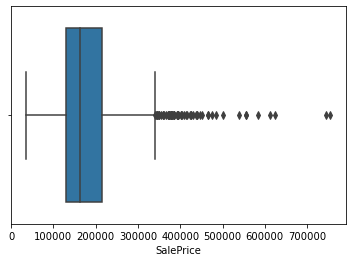

In [13]:
sns.boxplot(train_df[target])
plt.show()

In [14]:
q1 = np.percentile(train_df[target], 25)
q3 = np.percentile(train_df[target], 75)
iqr = q3 - q1
max_outlier = q3+1.5*iqr
print(f'Max outlier: {max_outlier}')
num_outliers = train_df[train_df['SalePrice'] > max_outlier].shape[0]
print(f'Percentage of outliers: {100*round(num_outliers/train_df.shape[0], 2)}')

Max outlier: 340037.5
Percentage of outliers: 4.0


#### Histogram of Sale Price

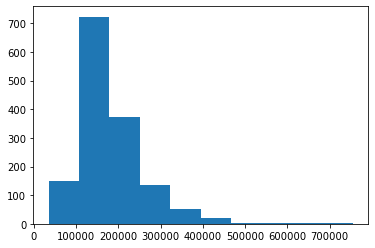

In [15]:
plt.hist(train_df['SalePrice'])
plt.show()

In [16]:
label = 'SalePrice'

### Correlation Matrix for all numerical variables

In [17]:
corr = train_df.corr()[label].sort_values()
valid_correlations = corr[(corr > 0.4) & (corr < 1)].index.tolist()
train_df[valid_correlations].corr()

,Fireplaces,MasVnrArea,GarageYrBlt,YearRemodAdd,YearBuilt,TotRmsAbvGrd,FullBath,1stFlrSF,TotalBsmtSF,GarageArea,GarageCars,GrLivArea,OverallQual,LogSalePrice
Fireplaces,1.000000,0.249070,0.046822,0.112581,0.147716,0.326114,0.243671,0.410531,0.339519,0.269141,0.300789,0.461679,0.396765,0.489450
MasVnrArea,0.249070,1.000000,0.252691,0.179618,0.315707,0.280682,0.276833,0.344501,0.363936,0.373066,0.364204,0.390857,0.411876,0.430809
GarageYrBlt,0.046822,0.252691,1.000000,0.642277,0.825667,0.148112,0.484557,0.233449,0.322445,0.564567,0.588920,0.231197,0.547766,0.541073
YearRemodAdd,0.112581,0.179618,0.642277,1.000000,0.592855,0.191740,0.439046,0.240379,0.291066,0.371600,0.420622,0.287389,0.550684,0.565608
YearBuilt,0.147716,0.315707,0.825667,0.592855,1.000000,0.095589,0.468271,0.281986,0.391452,0.478954,0.537850,0.199010,0.572323,0.586570
TotRmsAbvGrd,0.326114,0.280682,0.148112,0.191740,0.095589,1.000000,0.554784,0.409516,0.285573,0.337822,0.362289,0.825489,0.427452,0.534422
FullBath,0.243671,0.276833,0.484557,0.439046,0.468271,0.554784,1.000000,0.380637,0.323722,0.405656,0.469672,0.630012,0.550600,0.594771
1stFlrSF,0.410531,0.344501,0.233449,0.240379,0.281986,0.409516,0.380637,1.000000,0.819530,0.489782,0.439317,0.566024,0.476224,0.596981
TotalBsmtSF,0.339519,0.363936,0.322445,0.291066,0.391452,0.285573,0.323722,0.819530,1.000000,0.486665,0.434585,0.454868,0.537808,0.612134
GarageArea,0.269141,0.373066,0.564567,0.371600,0.478954,0.337822,0.405656,0.489782,0.486665,1.000000,0.882475,0.468997,0.562022,0.650888


In [18]:
# compartmentalize in another program

In [19]:
y_train = train_low_missing_vals_df['LogSalePrice']
train_model_data, test_model_data = data_manipulation.get_train_test_model_data(train_low_missing_vals_df, test_low_missing_vals_df,\
                                                                                numerical_variables, categorical_variables,\
                                                                                'SalePrice', target2='LogSalePrice')

train_drop_columns = list(set(train_model_data.columns) - set(test_model_data.columns))
train_model_data_final = train_model_data.drop(train_drop_columns, axis='columns')

## EDA (exploratory data analysis)

Why do garage variables have missing values?

In [20]:
garage_cols = get_columns(train_low_missing_vals_df, 'garage')
garage_cols

['GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond']

In [21]:
missing_value_df = missing_values.get_variable_missing_values(train_df).reset_index(drop=True).sort_values('percent_missing', ascending=False)

In [22]:
missing_value_df[missing_value_df['column_name'].isin(garage_cols)]

,column_name,percent_missing
58,GarageType,5.547945
59,GarageYrBlt,5.547945
64,GarageCond,5.547945
63,GarageQual,5.547945
60,GarageFinish,5.547945
61,GarageCars,0.000000
62,GarageArea,0.000000


In [23]:
train_low_missing_vals_df2 = train_low_missing_vals_df.copy()
test_low_missing_vals_df2 = test_low_missing_vals_df.copy()

#### Fill all garage columns missing values except GarageYrBlt with NA 

In [24]:
for f in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    #print(f'Variable: {f}, unique values: {train_df[f].unique()}')
    train_low_missing_vals_df2[f] = train_low_missing_vals_df2[f].fillna(value='NA')
    test_low_missing_vals_df2[f] = test_low_missing_vals_df2[f].fillna(value='NA')

In [25]:
train_df.isna().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageCond        81
GarageQual        81
GarageFinish      81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrType         8
MasVnrArea         8
Electrical         1
Id                 0
dtype: int64

In [26]:
missing_value_df.head(20)

,column_name,percent_missing
72,PoolQC,99.520548
74,MiscFeature,96.301370
6,Alley,93.767123
73,Fence,80.753425
57,FireplaceQu,47.260274
3,LotFrontage,17.739726
58,GarageType,5.547945
59,GarageYrBlt,5.547945
64,GarageCond,5.547945
63,GarageQual,5.547945


In [27]:
bsmt_missing_cols = ['BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond']

In [28]:
train_df[pd.isnull(train_df['GarageYrBlt'])]['GarageCars'].describe()

count    81.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: GarageCars, dtype: float64

In [29]:
train_df[pd.isnull(train_df['GarageYrBlt'])]['GarageArea'].describe()

count    81.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: GarageArea, dtype: float64

In [30]:
bsmt_cols = get_columns(train_low_missing_vals_df, 'bsmt')
bsmt_cols

['BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath']

In [31]:
train_df[pd.isnull(train_df['BsmtExposure'])]['TotalBsmtSF'].value_counts()

0      37
936     1
Name: TotalBsmtSF, dtype: int64

In [32]:
train_df[pd.isnull(train_df['BsmtExposure'])]['BsmtQual'].unique()

array([nan, 'Gd'], dtype=object)

The two cases where there are 1 more null BSMT exposure value than the other missing values, is because there is a basement, but it just has no exposure

In [33]:
train_df[(pd.isnull(train_df['BsmtExposure'])) & ~(pd.isnull(train_df['BsmtQual']))].index[0]

948

In [34]:
train_low_missing_vals_df2.loc[948, 'BsmtExposure']

nan

In [35]:
train_df[(pd.isnull(train_df['BsmtExposure'])) & ~(pd.isnull(train_df['BsmtQual']))][bsmt_cols]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
948,Gd,TA,NaN,Unf,0,Unf,0,936,936,0,0


In [36]:
train_low_missing_vals_df2.loc[948, 'BsmtExposure'] = 'NA'

The case where there is 1 more null BsmtFinType2 value than the other missing values for other basement columns, is because there is a basement, but it just has no second finish

In [37]:
train_df[(pd.isnull(train_df['BsmtFinType2'])) & ~(pd.isnull(train_df['BsmtQual']))][bsmt_cols]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
332,Gd,TA,No,GLQ,1124,NaN,479,1603,3206,1,0


In [38]:
train_low_missing_vals_df2.loc[332, 'BsmtFinType2'] = 'Unf'

In [39]:
train_low_missing_vals_df2.isna().sum()[bsmt_cols]

BsmtQual        37
BsmtCond        37
BsmtExposure    37
BsmtFinType1    37
BsmtFinSF1       0
BsmtFinType2    37
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
BsmtFullBath     0
BsmtHalfBath     0
dtype: int64

In [40]:
bsmt_missing_cols

['BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond']

All these remaining variables have missing values because they have no basement

Variable Distribution BsmtFinType1 Train Source Dataset


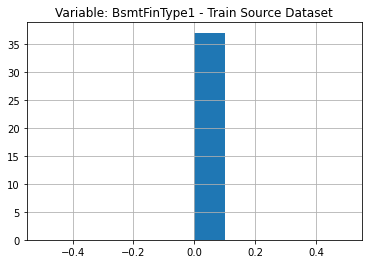

Variable Distribution BsmtFinType2 Train Source Dataset


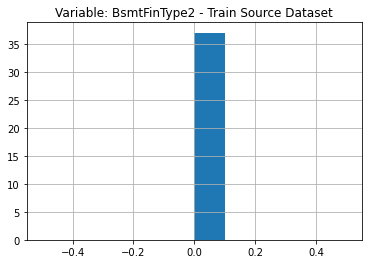

Variable Distribution BsmtExposure Train Source Dataset


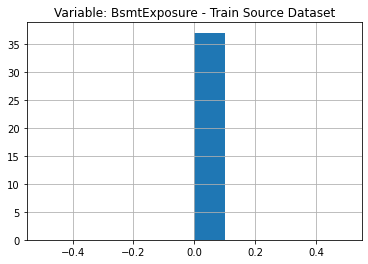

Variable Distribution BsmtQual Train Source Dataset


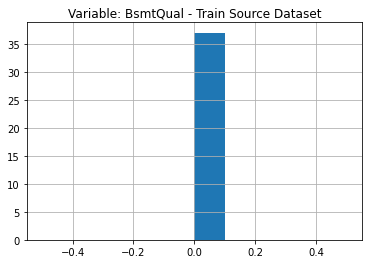

Variable Distribution BsmtCond Train Source Dataset


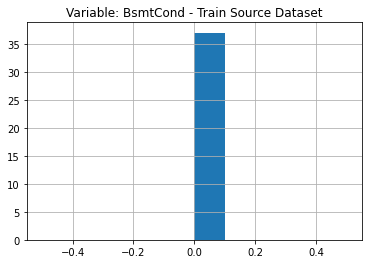

In [41]:
for c in bsmt_missing_cols:
    print(f'Variable Distribution {c} Train Source Dataset')
    train_low_missing_vals_df2[pd.isnull(train_low_missing_vals_df2[c])]['TotalBsmtSF'].hist()
    plt.title(f'Variable: {c} - Train Source Dataset')
    plt.show()

<AxesSubplot:>

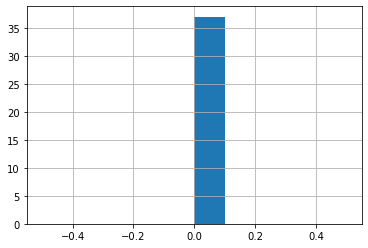

In [42]:
train_df[pd.isnull(train_df['BsmtCond'])]['TotalBsmtSF'].hist()

In [43]:
bsmt_missing_cols

['BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond']

In [44]:
for f in bsmt_missing_cols:
    #print(f'Variable: {f}, unique values: {train_df[f].unique()}')
    train_low_missing_vals_df2[f] = train_low_missing_vals_df2[f].fillna(value='NA')
    test_low_missing_vals_df2[f] = test_low_missing_vals_df2[f].fillna(value='NA')

In [45]:
garage_cols

['GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond']

<AxesSubplot:>

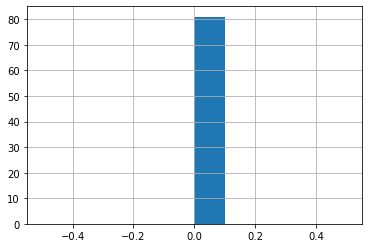

In [46]:
train_df[pd.isnull(train_df['GarageYrBlt'])]['GarageCars'].hist()

In [47]:
train_low_missing_vals_df2.isna().sum().sort_values(ascending=False).head(20)

LotFrontage     259
GarageYrBlt      81
MasVnrType        8
MasVnrArea        8
Electrical        1
BedroomAbvGr      0
Fireplaces        0
Functional        0
TotRmsAbvGrd      0
KitchenQual       0
KitchenAbvGr      0
HalfBath          0
FullBath          0
BsmtHalfBath      0
BsmtFullBath      0
GrLivArea         0
LowQualFinSF      0
2ndFlrSF          0
1stFlrSF          0
GarageType        0
dtype: int64

How to fill Garage Year Built? (Same as house year built?)

In [48]:
garage_house_same_time = train_df[(train_df['YearBuilt'] == train_df['GarageYrBlt'])]

<AxesSubplot:>

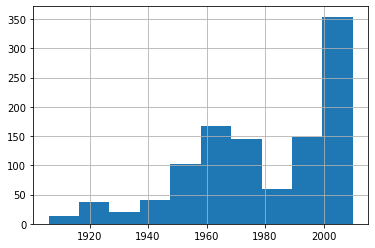

In [49]:
garage_house_same_time['YearBuilt'].hist()

In [50]:
garage_house_diff_time = train_df[(train_df['YearBuilt'] != train_df['GarageYrBlt'])]

In [51]:
garage_house_diff_time[(garage_house_diff_time['YearBuilt'] >= 1920) & (garage_house_diff_time['YearBuilt'] <= 1929)].shape[0]

56

In [52]:
garage_house_diff_time_decades = garage_house_diff_time.groupby((garage_house_diff_time['YearBuilt']//10)*10)['YearBuilt'].count()
garage_house_diff_time_decades = garage_house_diff_time_decades.rename('num_houses').reset_index().rename(columns={'YearBuilt':'decade'})
garage_house_same_time_decades = garage_house_same_time.groupby((garage_house_same_time['YearBuilt']//10)*10)['YearBuilt'].count()
garage_house_same_time_decades = garage_house_same_time_decades.rename('num_houses').reset_index().rename(columns={'YearBuilt':'decade'})

In [53]:
garage_house_built = garage_house_diff_time_decades.merge(garage_house_same_time_decades, how='outer', on='decade',\
                                                          suffixes=['_diff', '_same']).fillna(0)

garage_house_built['total'] = garage_house_built['num_houses_diff'] + garage_house_built['num_houses_same']
garage_house_built['same_ratio'] = garage_house_built['num_houses_same'] / garage_house_built['total']
garage_house_built['diff_ratio'] = garage_house_built['num_houses_diff'] / garage_house_built['total']

Houses built 1940 onwards, had garage built at the same time 

In [54]:
missing_value_df.head(20)

,column_name,percent_missing
72,PoolQC,99.520548
74,MiscFeature,96.301370
6,Alley,93.767123
73,Fence,80.753425
57,FireplaceQu,47.260274
3,LotFrontage,17.739726
58,GarageType,5.547945
59,GarageYrBlt,5.547945
64,GarageCond,5.547945
63,GarageQual,5.547945


In [55]:
garage_house_built

,decade,num_houses_diff,num_houses_same,total,same_ratio,diff_ratio
0,1870,2.0,0.0,2.0,0.000000,1.000000
1,1880,7.0,0.0,7.0,0.000000,1.000000
2,1890,6.0,0.0,6.0,0.000000,1.000000
3,1900,13.0,2.0,15.0,0.133333,0.866667
4,1910,45.0,13.0,58.0,0.224138,0.775862
5,1920,56.0,41.0,97.0,0.422680,0.577320
6,1930,29.0,25.0,54.0,0.462963,0.537037
7,1940,33.0,46.0,79.0,0.582278,0.417722
8,1950,44.0,123.0,167.0,0.736527,0.263473
9,1960,28.0,147.0,175.0,0.840000,0.160000


Percentage of houses with garages <b>NOT</b> built same time as the house 1940s and beyond

In [56]:
garage_house_built[garage_house_built['decade'] < 1940]['num_houses_diff'].sum()/garage_house_built[garage_house_built['decade'] < 1940]['total'].sum()

0.6610878661087866

Percentage of houses with garages built same time as the house 1940s and beyond

In [57]:
garage_house_built[garage_house_built['decade'] >= 1940]['num_houses_same'].sum()/garage_house_built[garage_house_built['decade'] >= 1940]['total'].sum()

0.8255528255528255

In [58]:
x_ = garage_house_diff_time[garage_house_diff_time['YearBuilt'] < 1940]
(x_['GarageYrBlt'] - x_['YearBuilt']).describe()

count    120.00000
mean      46.45000
std       28.77991
min      -10.00000
25%       21.75000
50%       46.00000
75%       69.25000
max      123.00000
dtype: float64

houses built before 1940, have garages built roughly 45 years (rounding down to nearest whole nice number) after house is built

In [59]:
missing_value_df.head(30)

,column_name,percent_missing
72,PoolQC,99.520548
74,MiscFeature,96.301370
6,Alley,93.767123
73,Fence,80.753425
57,FireplaceQu,47.260274
3,LotFrontage,17.739726
58,GarageType,5.547945
59,GarageYrBlt,5.547945
64,GarageCond,5.547945
63,GarageQual,5.547945


Houses built after 1940, had GarageYearBuilt = YearBuilt, before 1940 they were built roughly 45 years afterwards.

In [60]:
def fill_garage(row):
    #print(f'House built type: {type(house_built_date)}, value: {house_built_date}')
    if pd.isnull(row['GarageYrBlt']):
        if row['YearBuilt'] < 1940:
            return row['YearBuilt'] + 45
        else:
            return row['YearBuilt']
    else:
        return row['GarageYrBlt']

In [62]:
train_low_missing_vals_df2['GarageYrBlt'] = train_low_missing_vals_df2.\
                                        apply(lambda row: fill_garage(row) , axis='columns')

In [63]:
train_low_missing_vals_df2['GarageYrBlt'].isna().sum()

0

Fill garage size with similar size house average

Fill lot frontage based on neighborhood average lot frontage 

In [481]:
neighborhood_avg_lot_frontage = train_df.groupby('Neighborhood')['LotFrontage'].mean().reset_index().sort_values('LotFrontage', ascending=False)
neighborhood_avg_lot_frontage

,Neighborhood,LotFrontage
15,NoRidge,91.878788
4,ClearCr,83.461538
16,NridgHt,81.881579
14,NWAmes,81.288889
23,Timber,80.133333
8,Gilbert,79.877551
12,NAmes,76.462366
19,Sawyer,74.437500
6,Crawfor,71.804878
5,CollgCr,71.682540


In [482]:
train_df['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [483]:
ind_continuous_variables

['WoodDeckSF',
 'BsmtFinSF1',
 '2ndFlrSF',
 'OpenPorchSF',
 'ScreenPorch',
 'BsmtUnfSF',
 'YearRemodAdd',
 'GrLivArea',
 '1stFlrSF',
 'EnclosedPorch',
 'LotFrontage',
 'BsmtFinSF2',
 'GarageYrBlt',
 'YearBuilt',
 'LowQualFinSF',
 '3SsnPorch',
 'TotalBsmtSF',
 'MasVnrArea',
 'MiscVal',
 'PoolArea',
 'LotArea',
 'GarageArea']

In [65]:
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

categorical_variables, discrete_numerical_variables,\
continuous_numerical_variables = data_manipulation.get_variables(train_low_missing_vals_df2, [], 'Id')
discrete_numerical_variables = list(set(discrete_numerical_variables) - set(['PoolArea']))
continuous_numerical_variables = continuous_numerical_variables + ['PoolArea']
ind_continuous_variables = list(set(continuous_numerical_variables) - set(['SalePrice', 'LogSalePrice']))
numerical_variables = continuous_numerical_variables + discrete_numerical_variables

categorical_columns_selector = selector(dtype_exclude='number')
categorical_columns = categorical_columns_selector(train_low_missing_vals_df2)

ohe2 = OneHotEncoder(handle_unknown='ignore', sparse=False)
categorical_pipeline2 = make_pipeline(categorical_imputer, ohe2)



preprocessor2 = make_column_transformer((categorical_pipeline2, categorical_columns),
                                       (numerical_imputer, ind_continuous_variables),
                                       (categorical_imputer, discrete_numerical_variables),
                                    )

### Version 1.1 Stacking Regressor GarageYrBuilt data manipulation

In [74]:
%%time
xgb_final_pipe, xgb_score, xgb_best_params = get_pipeline_cross_val_score(preprocessor2, XGBRegressor, xgb_param_grid, train_low_missing_vals_df2, y_train)
lasso_final_pipe, lasso_score, lasso_best_params = get_pipeline_cross_val_score(preprocessor2, Lasso, lasso_param_grid, train_low_missing_vals_df2, y_train)
ridge_final_pipe, ridge_score, ridge_best_params = get_pipeline_cross_val_score(preprocessor2, Ridge, ridge_param_grid, train_low_missing_vals_df2, y_train)
elastic_net_final_pipe, elastic_net_score, elastic_net_best_params = get_pipeline_cross_val_score(preprocessor2, ElasticNet, elastic_net_param_grid, train_low_missing_vals_df2, y_train)
knn_final_pipe, knn_score, knn_best_params = get_pipeline_cross_val_score(preprocessor2, KNeighborsRegressor, knn_param_grid, train_low_missing_vals_df2, y_train)

Model name: XGBRegressor
Model name: Lasso
Scaling Pipe: Lasso


C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 19 is smaller than n_iter=50. Running 19 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Scaling Final Pipe: Lasso
Model name: Ridge
Scaling Pipe: Ridge


C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 19 is smaller than n_iter=50. Running 19 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Scaling Final Pipe: Ridge
Model name: ElasticNet
Scaling Pipe: ElasticNet
Scaling Final Pipe: ElasticNet
Model name: KNeighborsRegressor


C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 6 is smaller than n_iter=50. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CPU times: total: 22min 21s
Wall time: 4min 2s


In [75]:
%%time
estimators = [
 ('KNN', knn_final_pipe),
    ('Lasso', lasso_final_pipe),
    ('Ridge', ridge_final_pipe),
    ('Elastic', elastic_net_final_pipe),
    ('XGBRegressor', xgb_final_pipe)
]


final_estimator=RandomForestRegressor()

rf_stacking_regressor = StackingRegressor(
        estimators=estimators,
        final_estimator=final_estimator,
    )

-cross_val_score(rf_stacking_regressor, train_low_missing_vals_df2, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

CPU times: total: 2min 47s
Wall time: 40.2 s


0.12639326643462814

## Correcting Data for Skew

Pipelines are done sequentially, column transformer runs in parallel

In [257]:
missing_value_pct_threshold = 30
train_drop = missing_values.get_high_missing_value_columns(train_df, missing_value_pct_threshold)
test_drop = missing_values.get_high_missing_value_columns(test_df, missing_value_pct_threshold)

train_low_missing_vals_df = train_df.drop(train_drop, axis='columns')
test_low_missing_vals_df = test_df.drop(test_drop, axis='columns')

In [258]:
ohe = OneHotEncoder(handle_unknown='ignore')
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')
ordinal_imputer = SimpleImputer(strategy='most_frequent')

In [259]:
categorical_variables, discrete_numerical_variables,\
continuous_numerical_variables = data_manipulation.get_variables(train_low_missing_vals_df, [], 'Id')
discrete_numerical_variables = list(set(discrete_numerical_variables) - set(['PoolArea']))
continuous_numerical_variables = continuous_numerical_variables + ['PoolArea']
ind_continuous_variables = list(set(continuous_numerical_variables) - set(['SalePrice', 'LogSalePrice']))
numerical_variables = continuous_numerical_variables + discrete_numerical_variables

Variable: MSSubClass


20     0.367123
60     0.204795
50     0.098630
120    0.059589
30     0.047260
160    0.043151
70     0.041096
80     0.039726
90     0.035616
190    0.020548
85     0.013699
75     0.010959
45     0.008219
180    0.006849
40     0.002740
Name: MSSubClass, dtype: float64

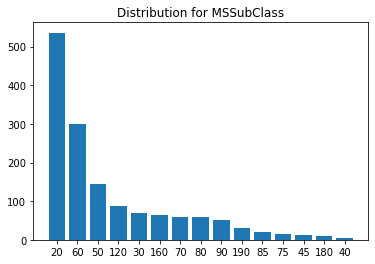

Variable: MSZoning


RL    0.788356
RM    0.149315
FV    0.044521
RH    0.010959
C     0.006849
Name: MSZoning, dtype: float64

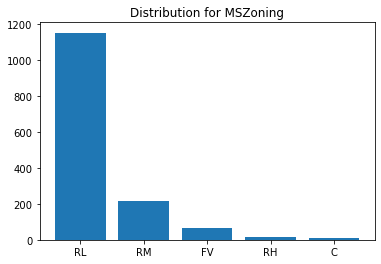

Variable: Street


Pave    0.99589
Grvl    0.00411
Name: Street, dtype: float64

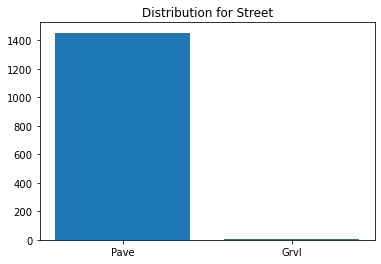

Variable: LotShape


Reg    0.633562
IR1    0.331507
IR2    0.028082
IR3    0.006849
Name: LotShape, dtype: float64

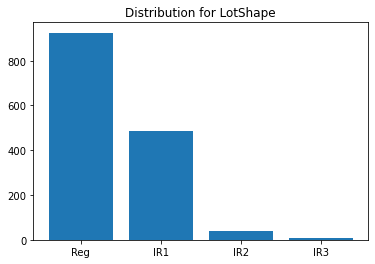

Variable: LandContour


Lvl    0.897945
Bnk    0.043151
HLS    0.034247
Low    0.024658
Name: LandContour, dtype: float64

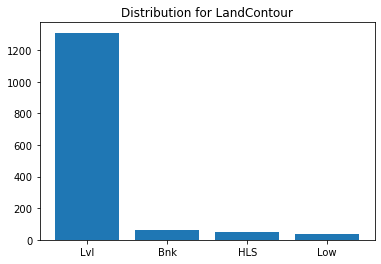

Variable: Utilities


AllPub    0.999315
NoSeWa    0.000685
Name: Utilities, dtype: float64

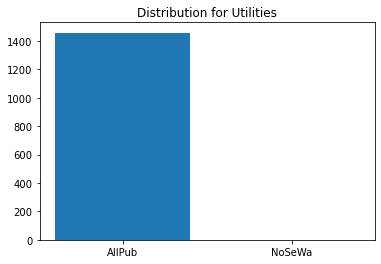

Variable: LotConfig


Inside     0.720548
Corner     0.180137
CulDSac    0.064384
FR2        0.032192
FR3        0.002740
Name: LotConfig, dtype: float64

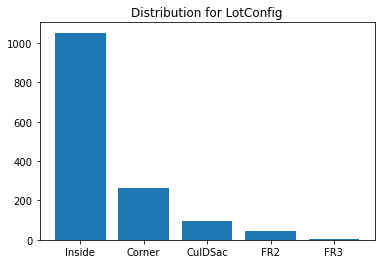

Variable: LandSlope


Gtl    0.946575
Mod    0.044521
Sev    0.008904
Name: LandSlope, dtype: float64

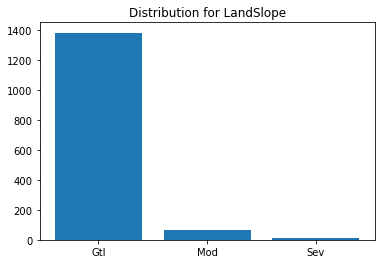

Variable: Neighborhood


NAmes      0.154110
CollgCr    0.102740
OldTown    0.077397
Edwards    0.068493
Somerst    0.058904
Gilbert    0.054110
NridgHt    0.052740
Sawyer     0.050685
NWAmes     0.050000
SawyerW    0.040411
BrkSide    0.039726
Crawfor    0.034932
Mitchel    0.033562
NoRidge    0.028082
Timber     0.026027
IDOTRR     0.025342
ClearCr    0.019178
StoneBr    0.017123
SWISU      0.017123
MeadowV    0.011644
Blmngtn    0.011644
BrDale     0.010959
Veenker    0.007534
NPkVill    0.006164
Blueste    0.001370
Name: Neighborhood, dtype: float64

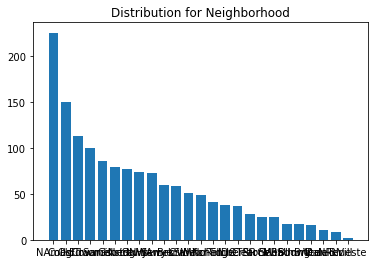

Variable: Condition1


Norm      0.863014
Feedr     0.055479
Artery    0.032877
RRAn      0.017808
PosN      0.013014
RRAe      0.007534
PosA      0.005479
RRNn      0.003425
RRNe      0.001370
Name: Condition1, dtype: float64

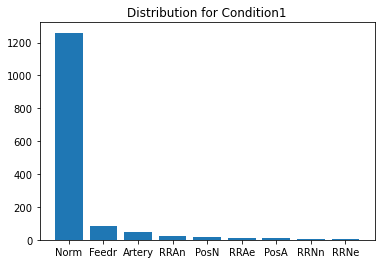

Variable: Condition2


Norm      0.989726
Feedr     0.004110
Artery    0.001370
RRNn      0.001370
PosN      0.001370
PosA      0.000685
RRAn      0.000685
RRAe      0.000685
Name: Condition2, dtype: float64

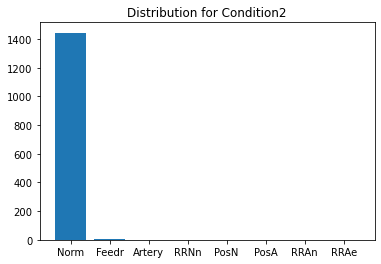

Variable: BldgType


1Fam      0.835616
TwnhsE    0.078082
Duplex    0.035616
Twnhs     0.029452
2fmCon    0.021233
Name: BldgType, dtype: float64

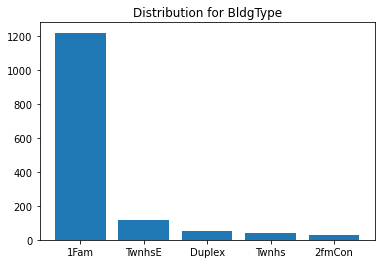

Variable: HouseStyle


1Story    0.497260
2Story    0.304795
1.5Fin    0.105479
SLvl      0.044521
SFoyer    0.025342
1.5Unf    0.009589
2.5Unf    0.007534
2.5Fin    0.005479
Name: HouseStyle, dtype: float64

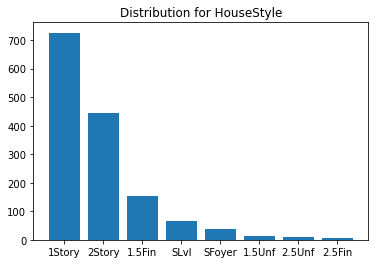

Variable: RoofStyle


Gable      0.781507
Hip        0.195890
Flat       0.008904
Gambrel    0.007534
Mansard    0.004795
Shed       0.001370
Name: RoofStyle, dtype: float64

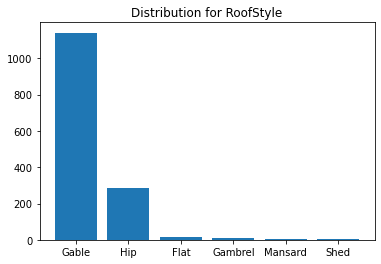

Variable: RoofMatl


CompShg    0.982192
Tar&Grv    0.007534
WdShngl    0.004110
WdShake    0.003425
Metal      0.000685
Membran    0.000685
Roll       0.000685
ClyTile    0.000685
Name: RoofMatl, dtype: float64

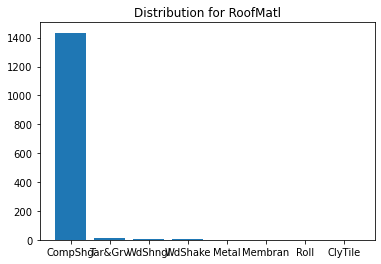

Variable: Exterior1st


VinylSd    0.352740
HdBoard    0.152055
MetalSd    0.150685
Wd Sdng    0.141096
Plywood    0.073973
CemntBd    0.041781
BrkFace    0.034247
WdShing    0.017808
Stucco     0.017123
AsbShng    0.013699
BrkComm    0.001370
Stone      0.001370
AsphShn    0.000685
ImStucc    0.000685
CBlock     0.000685
Name: Exterior1st, dtype: float64

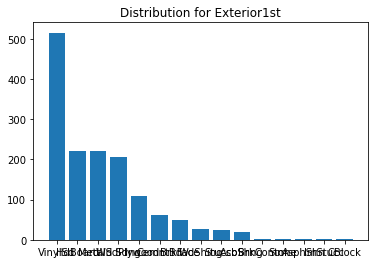

Variable: Exterior2nd


VinylSd    0.345205
MetalSd    0.146575
HdBoard    0.141781
Wd Sdng    0.134932
Plywood    0.097260
CmentBd    0.041096
Wd Shng    0.026027
Stucco     0.017808
BrkFace    0.017123
AsbShng    0.013699
ImStucc    0.006849
Brk Cmn    0.004795
Stone      0.003425
AsphShn    0.002055
Other      0.000685
CBlock     0.000685
Name: Exterior2nd, dtype: float64

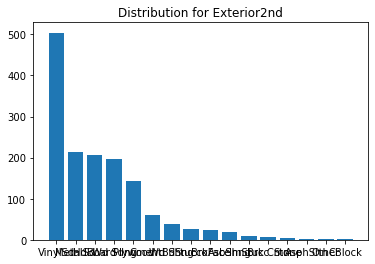

Variable: MasVnrType


None       0.595041
BrkFace    0.306474
Stone      0.088154
BrkCmn     0.010331
Name: MasVnrType, dtype: float64

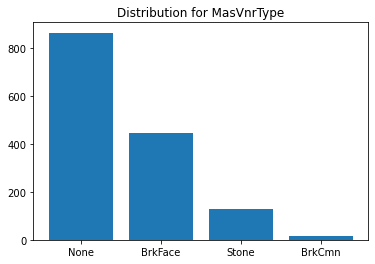

Variable: ExterQual


TA    0.620548
Gd    0.334247
Ex    0.035616
Fa    0.009589
Name: ExterQual, dtype: float64

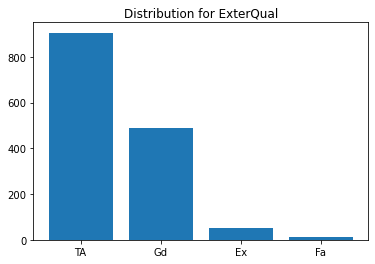

Variable: ExterCond


TA    0.878082
Gd    0.100000
Fa    0.019178
Ex    0.002055
Po    0.000685
Name: ExterCond, dtype: float64

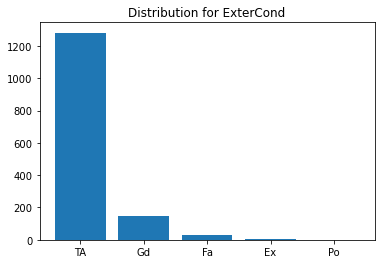

Variable: Foundation


PConc     0.443151
CBlock    0.434247
BrkTil    0.100000
Slab      0.016438
Stone     0.004110
Wood      0.002055
Name: Foundation, dtype: float64

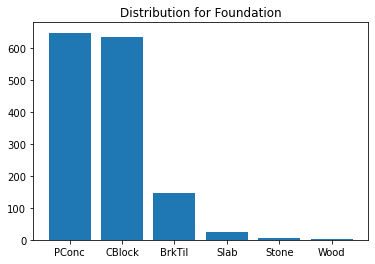

Variable: BsmtQual


TA    0.456079
Gd    0.434294
Ex    0.085032
Fa    0.024596
Name: BsmtQual, dtype: float64

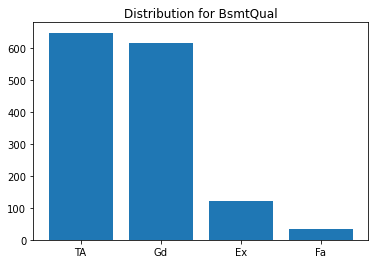

Variable: BsmtCond


TA    0.921293
Gd    0.045678
Fa    0.031623
Po    0.001405
Name: BsmtCond, dtype: float64

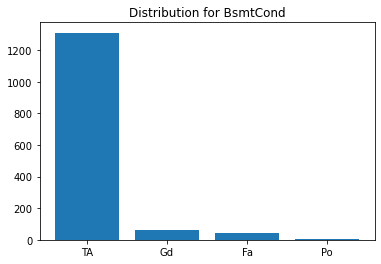

Variable: BsmtExposure


No    0.670183
Av    0.155415
Gd    0.094233
Mn    0.080169
Name: BsmtExposure, dtype: float64

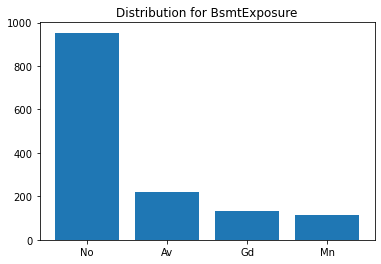

Variable: BsmtFinType1


Unf    0.302178
GLQ    0.293746
ALQ    0.154603
BLQ    0.104006
Rec    0.093465
LwQ    0.052003
Name: BsmtFinType1, dtype: float64

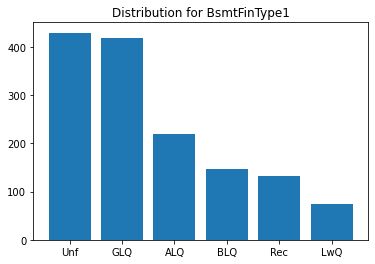

Variable: BsmtFinType2


Unf    0.883263
Rec    0.037975
LwQ    0.032349
BLQ    0.023207
ALQ    0.013361
GLQ    0.009845
Name: BsmtFinType2, dtype: float64

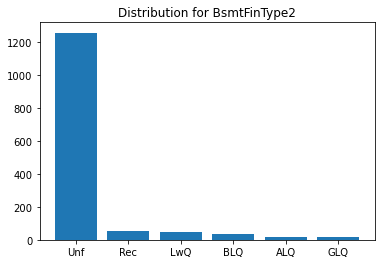

Variable: Heating


GasA     0.978082
GasW     0.012329
Grav     0.004795
Wall     0.002740
OthW     0.001370
Floor    0.000685
Name: Heating, dtype: float64

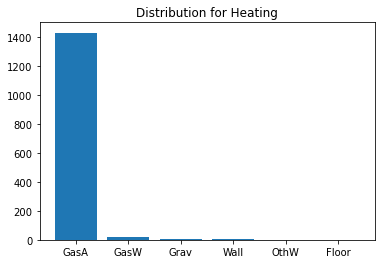

Variable: HeatingQC


Ex    0.507534
TA    0.293151
Gd    0.165068
Fa    0.033562
Po    0.000685
Name: HeatingQC, dtype: float64

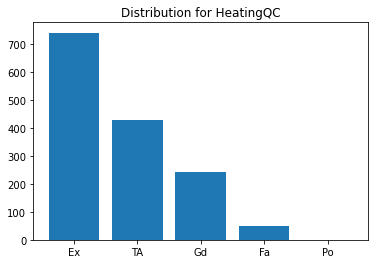

Variable: CentralAir


Y    0.934932
N    0.065068
Name: CentralAir, dtype: float64

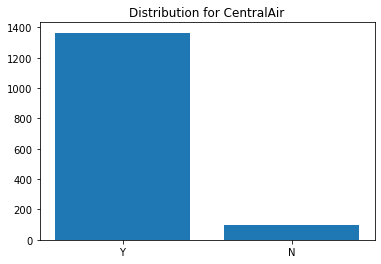

Variable: Electrical


SBrkr    0.914325
FuseA    0.064428
FuseF    0.018506
FuseP    0.002056
Mix      0.000685
Name: Electrical, dtype: float64

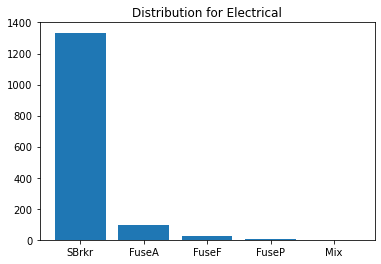

Variable: KitchenQual


TA    0.503425
Gd    0.401370
Ex    0.068493
Fa    0.026712
Name: KitchenQual, dtype: float64

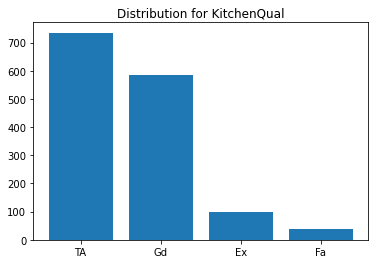

Variable: Functional


Typ     0.931507
Min2    0.023288
Min1    0.021233
Mod     0.010274
Maj1    0.009589
Maj2    0.003425
Sev     0.000685
Name: Functional, dtype: float64

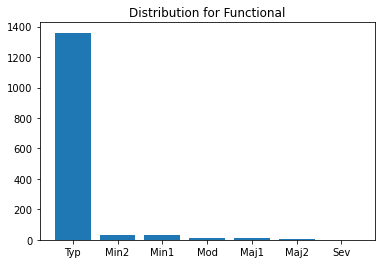

Variable: GarageType


Attchd     0.630892
Detchd     0.280638
BuiltIn    0.063814
Basment    0.013778
CarPort    0.006526
2Types     0.004351
Name: GarageType, dtype: float64

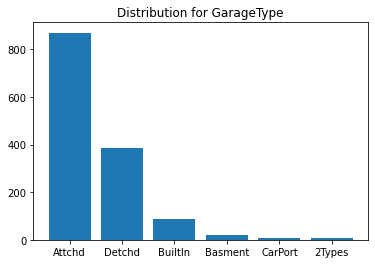

Variable: GarageFinish


Unf    0.438724
RFn    0.306019
Fin    0.255257
Name: GarageFinish, dtype: float64

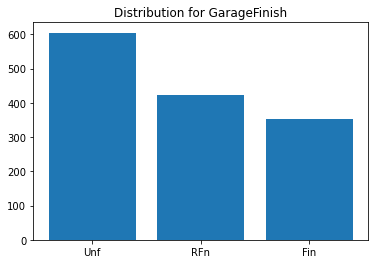

Variable: GarageQual


TA    0.950689
Fa    0.034808
Gd    0.010152
Ex    0.002175
Po    0.002175
Name: GarageQual, dtype: float64

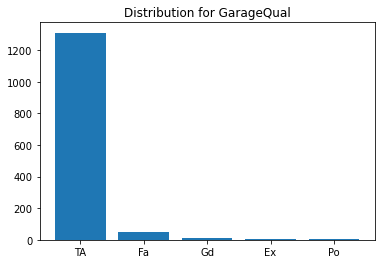

Variable: GarageCond


TA    0.961566
Fa    0.025381
Gd    0.006526
Po    0.005076
Ex    0.001450
Name: GarageCond, dtype: float64

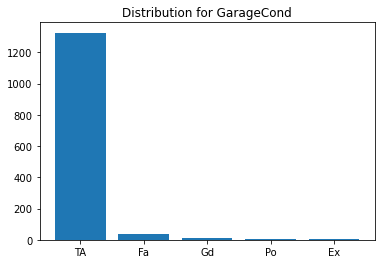

Variable: PavedDrive


Y    0.917808
N    0.061644
P    0.020548
Name: PavedDrive, dtype: float64

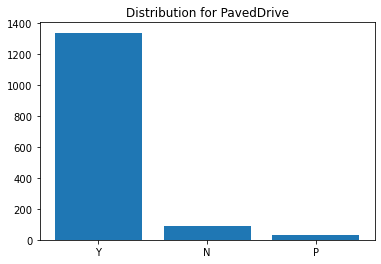

Variable: SaleType


WD       0.867808
New      0.083562
COD      0.029452
ConLD    0.006164
ConLI    0.003425
ConLw    0.003425
CWD      0.002740
Oth      0.002055
Con      0.001370
Name: SaleType, dtype: float64

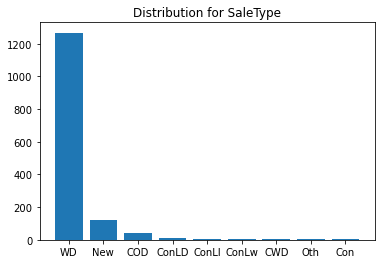

Variable: SaleCondition


Normal     0.820548
Partial    0.085616
Abnorml    0.069178
Family     0.013699
Alloca     0.008219
AdjLand    0.002740
Name: SaleCondition, dtype: float64

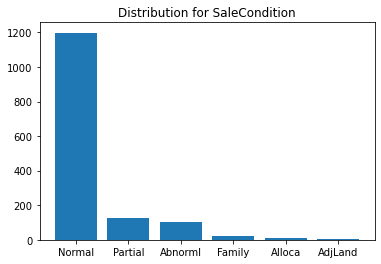

In [247]:
plot_cat_variable_dist(train_low_missing_vals_df, categorical_columns)

Variable: BsmtHalfBath


0    0.943836
1    0.054795
2    0.001370
Name: BsmtHalfBath, dtype: float64

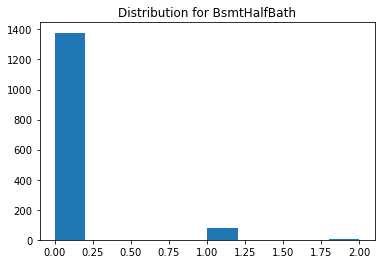

Variable: OverallCond


5    0.562329
6    0.172603
7    0.140411
8    0.049315
4    0.039041
3    0.017123
9    0.015068
2    0.003425
1    0.000685
Name: OverallCond, dtype: float64

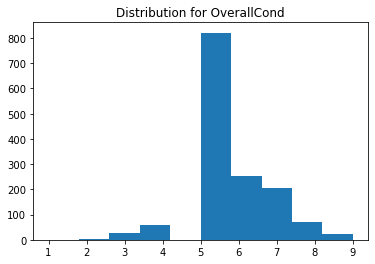

Variable: BedroomAbvGr


3    0.550685
2    0.245205
4    0.145890
1    0.034247
5    0.014384
6    0.004795
0    0.004110
8    0.000685
Name: BedroomAbvGr, dtype: float64

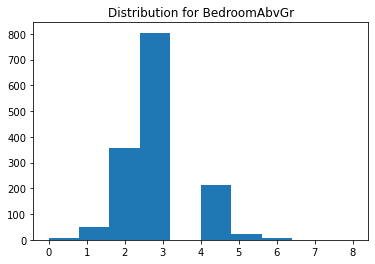

Variable: MoSold


6     0.173288
7     0.160274
5     0.139726
4     0.096575
8     0.083562
3     0.072603
10    0.060959
11    0.054110
9     0.043151
12    0.040411
1     0.039726
2     0.035616
Name: MoSold, dtype: float64

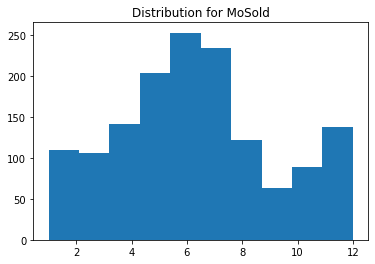

Variable: BsmtFullBath


0    0.586301
1    0.402740
2    0.010274
3    0.000685
Name: BsmtFullBath, dtype: float64

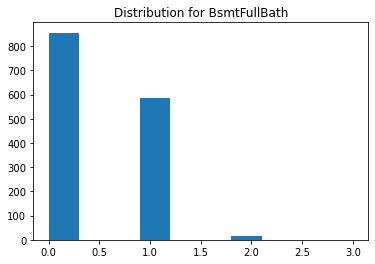

Variable: HalfBath


0    0.625342
1    0.366438
2    0.008219
Name: HalfBath, dtype: float64

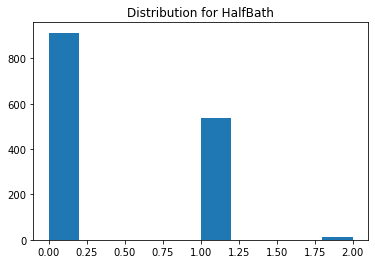

Variable: TotRmsAbvGrd


6     0.275342
7     0.225342
5     0.188356
8     0.128082
4     0.066438
9     0.051370
10    0.032192
11    0.012329
3     0.011644
12    0.007534
2     0.000685
14    0.000685
Name: TotRmsAbvGrd, dtype: float64

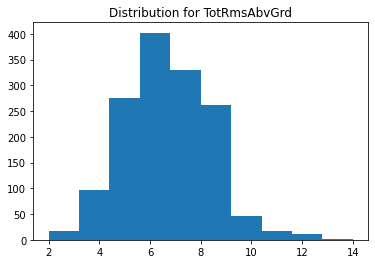

Variable: KitchenAbvGr


1    0.953425
2    0.044521
3    0.001370
0    0.000685
Name: KitchenAbvGr, dtype: float64

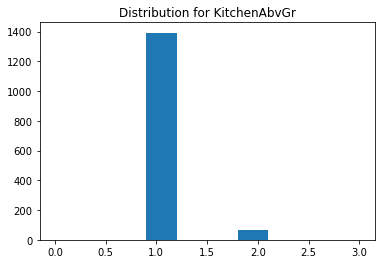

Variable: OverallQual


5     0.271918
6     0.256164
7     0.218493
8     0.115068
4     0.079452
9     0.029452
3     0.013699
10    0.012329
2     0.002055
1     0.001370
Name: OverallQual, dtype: float64

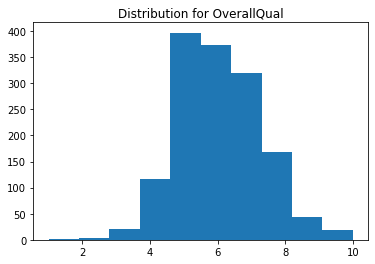

Variable: YrSold


2009    0.231507
2007    0.225342
2006    0.215068
2008    0.208219
2010    0.119863
Name: YrSold, dtype: float64

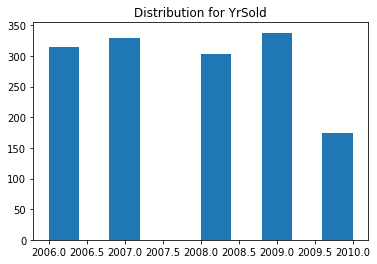

Variable: FullBath


2    0.526027
1    0.445205
3    0.022603
0    0.006164
Name: FullBath, dtype: float64

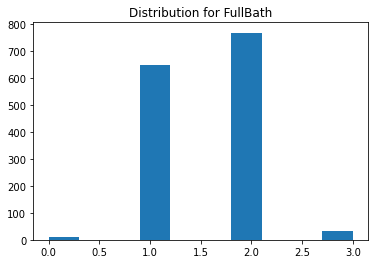

Variable: Fireplaces


0    0.472603
1    0.445205
2    0.078767
3    0.003425
Name: Fireplaces, dtype: float64

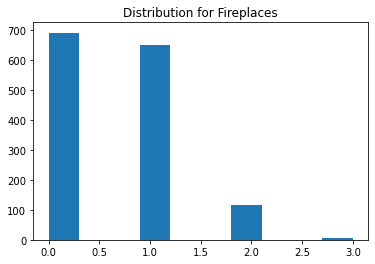

Variable: GarageCars


2    0.564384
1    0.252740
3    0.123973
0    0.055479
4    0.003425
Name: GarageCars, dtype: float64

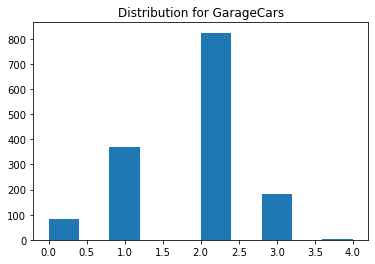

In [244]:
plot_discrete_variable_dist(train_low_missing_vals_df, discrete_numerical_variables)

Variable: WoodDeckSF


count    1460.000000
mean       94.244521
std       125.338794
min         0.000000
25%         0.000000
50%         0.000000
75%       168.000000
max       857.000000
Name: WoodDeckSF, dtype: float64

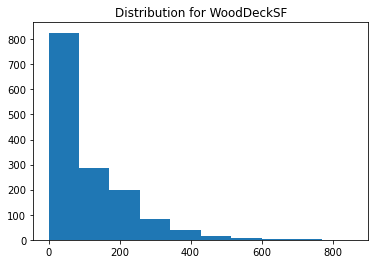

Variable: BsmtFinSF1


count    1460.000000
mean      443.639726
std       456.098091
min         0.000000
25%         0.000000
50%       383.500000
75%       712.250000
max      5644.000000
Name: BsmtFinSF1, dtype: float64

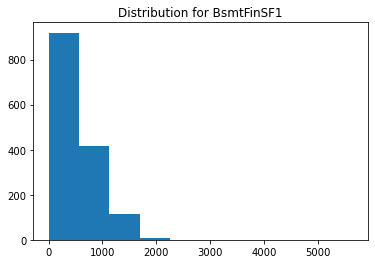

Variable: 2ndFlrSF


count    1460.000000
mean      346.992466
std       436.528436
min         0.000000
25%         0.000000
50%         0.000000
75%       728.000000
max      2065.000000
Name: 2ndFlrSF, dtype: float64

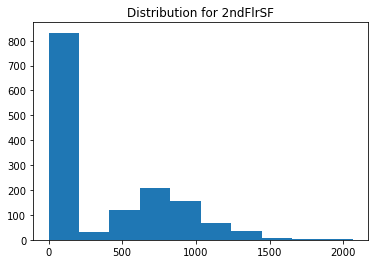

Variable: OpenPorchSF


count    1460.000000
mean       46.660274
std        66.256028
min         0.000000
25%         0.000000
50%        25.000000
75%        68.000000
max       547.000000
Name: OpenPorchSF, dtype: float64

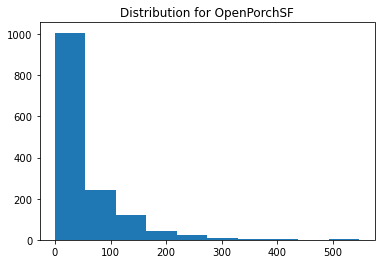

Variable: ScreenPorch


count    1460.000000
mean       15.060959
std        55.757415
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       480.000000
Name: ScreenPorch, dtype: float64

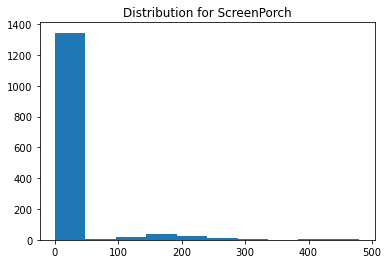

Variable: BsmtUnfSF


count    1460.000000
mean      567.240411
std       441.866955
min         0.000000
25%       223.000000
50%       477.500000
75%       808.000000
max      2336.000000
Name: BsmtUnfSF, dtype: float64

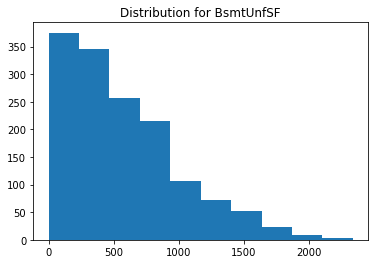

Variable: YearRemodAdd


count    1460.000000
mean     1984.865753
std        20.645407
min      1950.000000
25%      1967.000000
50%      1994.000000
75%      2004.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64

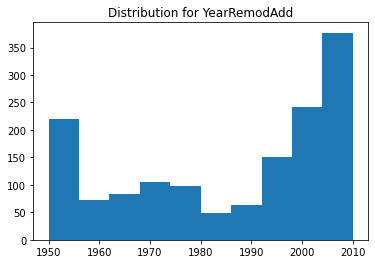

Variable: GrLivArea


count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

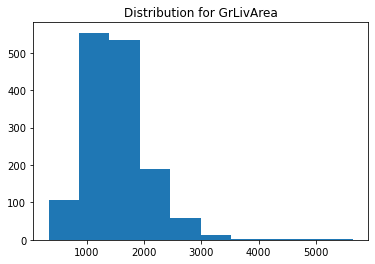

Variable: 1stFlrSF


count    1460.000000
mean     1162.626712
std       386.587738
min       334.000000
25%       882.000000
50%      1087.000000
75%      1391.250000
max      4692.000000
Name: 1stFlrSF, dtype: float64

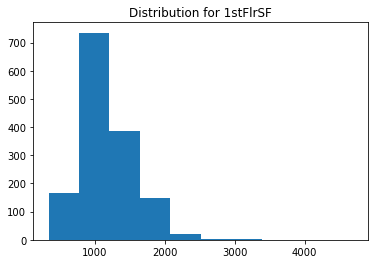

Variable: EnclosedPorch


count    1460.000000
mean       21.954110
std        61.119149
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       552.000000
Name: EnclosedPorch, dtype: float64

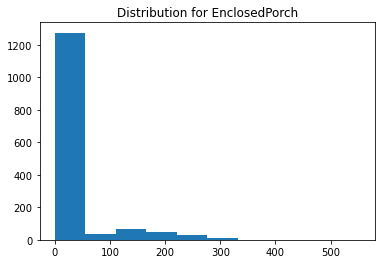

Variable: LotFrontage


count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

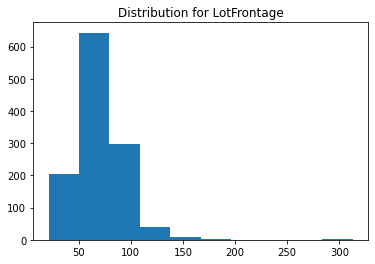

Variable: BsmtFinSF2


count    1460.000000
mean       46.549315
std       161.319273
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1474.000000
Name: BsmtFinSF2, dtype: float64

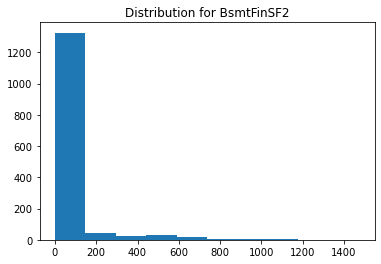

Variable: GarageYrBlt


count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

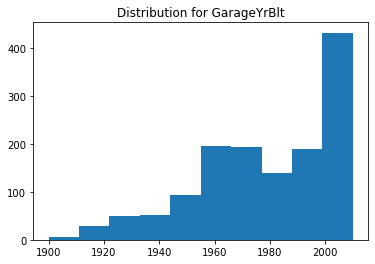

Variable: YearBuilt


count    1460.000000
mean     1971.267808
std        30.202904
min      1872.000000
25%      1954.000000
50%      1973.000000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64

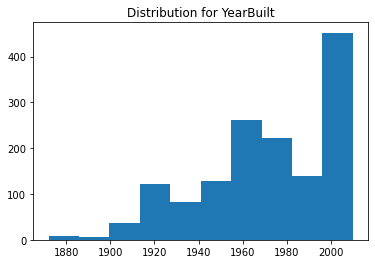

Variable: LowQualFinSF


count    1460.000000
mean        5.844521
std        48.623081
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       572.000000
Name: LowQualFinSF, dtype: float64

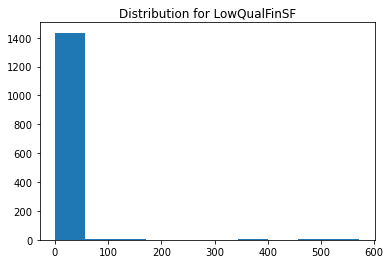

Variable: 3SsnPorch


count    1460.000000
mean        3.409589
std        29.317331
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       508.000000
Name: 3SsnPorch, dtype: float64

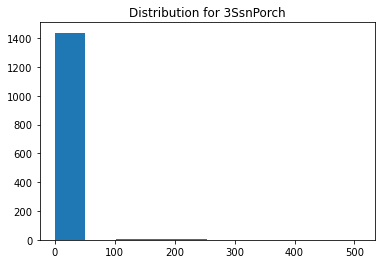

Variable: TotalBsmtSF


count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       795.750000
50%       991.500000
75%      1298.250000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

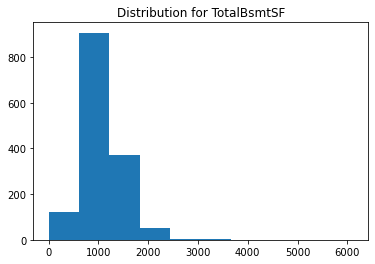

Variable: MasVnrArea


count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

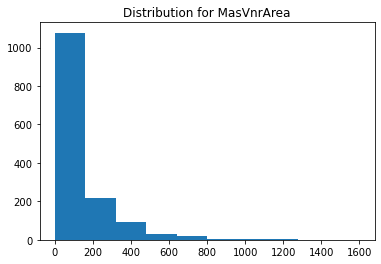

Variable: MiscVal


count     1460.000000
mean        43.489041
std        496.123024
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      15500.000000
Name: MiscVal, dtype: float64

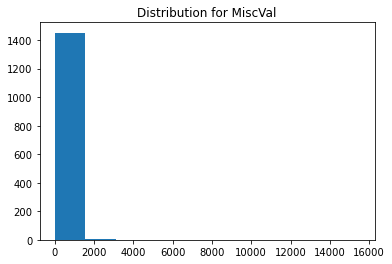

Variable: LotArea


count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

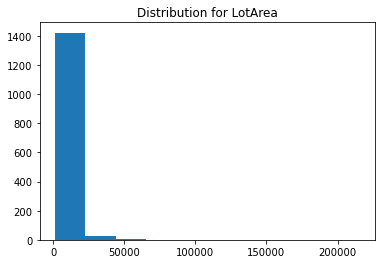

Variable: GarageArea


count    1460.000000
mean      472.980137
std       213.804841
min         0.000000
25%       334.500000
50%       480.000000
75%       576.000000
max      1418.000000
Name: GarageArea, dtype: float64

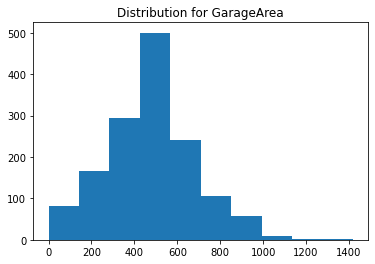

In [246]:
plot_variable_dist(train_low_missing_vals_df, ind_continuous_variables)

In [260]:
numerical_columns_selector = selector(dtype_exclude=object)

numerical_columns = numerical_columns_selector(train_low_missing_vals_df)
numerical_columns = list(set(numerical_columns) - set(['SalePrice', 'LogSalePrice', 'Id']))

In [262]:
categorical_columns_selector = selector(dtype_exclude='number')
categorical_columns = categorical_columns_selector(train_low_missing_vals_df)

In [240]:
ohe2 = OneHotEncoder(handle_unknown='ignore', sparse=False)
categorical_pipeline2 = make_pipeline(categorical_imputer, ohe2)

In [24]:
categorical_pipeline = make_pipeline(categorical_imputer, ohe)
skewed_numerical_pipeline = make_pipeline(log_transformer, numerical_imputer)
skewed_discrete_pipeline = make_pipeline(log_transformer, categorical_imputer)

In [264]:
preprocessor2 = make_column_transformer((categorical_pipeline2, categorical_columns),
                                       (numerical_imputer, ind_continuous_variables),
                                       (categorical_imputer, discrete_numerical_variables),
                                    )

### Version 1: RF Stacking Regressor with no log transform

In [266]:
%%time
xgb_final_pipe, xgb_score, xgb_best_params = get_pipeline_cross_val_score(preprocessor2, XGBRegressor, xgb_param_grid, train_low_missing_vals_df, y_train)
lasso_final_pipe, lasso_score, lasso_best_params = get_pipeline_cross_val_score(preprocessor2, Lasso, lasso_param_grid, train_low_missing_vals_df, y_train)
ridge_final_pipe, ridge_score, ridge_best_params = get_pipeline_cross_val_score(preprocessor2, Ridge, ridge_param_grid, train_low_missing_vals_df, y_train)
elastic_net_final_pipe, elastic_net_score, elastic_net_best_params = get_pipeline_cross_val_score(preprocessor2, ElasticNet, elastic_net_param_grid, train_low_missing_vals_df, y_train)
knn_final_pipe, knn_score, knn_best_params = get_pipeline_cross_val_score(preprocessor2, KNeighborsRegressor, knn_param_grid, train_low_missing_vals_df, y_train)

model: <class 'xgboost.sklearn.XGBRegressor'>, class: XGBRegressor
model: <class 'sklearn.linear_model._coordinate_descent.Lasso'>, class: Lasso
scaling


C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 19 is smaller than n_iter=50. Running 19 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Scaling
model: <class 'sklearn.linear_model._ridge.Ridge'>, class: Ridge
scaling


C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 19 is smaller than n_iter=50. Running 19 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Scaling
model: <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>, class: ElasticNet
scaling
Scaling
model: <class 'sklearn.neighbors._regression.KNeighborsRegressor'>, class: KNeighborsRegressor


C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 6 is smaller than n_iter=50. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CPU times: total: 9min 26s
Wall time: 1min 50s


In [267]:
%%time
estimators = [
 ('KNN', knn_final_pipe),
    ('Lasso', lasso_final_pipe),
    ('Ridge', ridge_final_pipe),
    ('Elastic', elastic_net_final_pipe),
    ('XGBRegressor', xgb_final_pipe)
]


final_estimator=RandomForestRegressor()

rf_stacking_regressor = StackingRegressor(
        estimators=estimators,
        final_estimator=final_estimator,
    )

-cross_val_score(rf_stacking_regressor, train_low_missing_vals_df, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

CPU times: total: 1min 14s
Wall time: 19.1 s


0.12544298994833897

In [268]:
rf_stacking_regressor = rf_stacking_regressor.fit(train_low_missing_vals_df, y_train)
test_pred = rf_stacking_regressor.predict(test_low_missing_vals_df)
test_pred = np.expm1(test_pred)
test_df['PredictedSalePrice'] = test_pred
pred = test_df[['Id', 'PredictedSalePrice']]
columns = dict()
columns['PredictedSalePrice'] = 'SalePrice'
pred = pred.rename(columns=columns)
pred.to_csv('stacking_regressor_rf_v1.csv', index=False)

### Version 2: Random Forest Stacking Regressor log transform

In [233]:
%%time
estimators = [
 ('KNN', knn_final_pipe),
    ('Lasso', lasso_final_pipe),
    ('Ridge', ridge_final_pipe),
    ('Elastic', elastic_net_final_pipe),
    ('XGBRegressor', xgb_final_pipe)
]


final_estimator=RandomForestRegressor()

rf_stacking_regressor = StackingRegressor(
        estimators=estimators,
        final_estimator=final_estimator,
    )

-cross_val_score(rf_stacking_regressor, train_low_missing_vals_df, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

CPU times: total: 1min 1s
Wall time: 14.6 s


0.12648735913831666

In [37]:
rf_stacking_regressor = rf_stacking_regressor.fit(train_low_missing_vals_df, y_train)
test_pred = rf_stacking_regressor.predict(test_low_missing_vals_df)
test_pred = np.expm1(test_pred)
test_df['PredictedSalePrice'] = test_pred
pred = test_df[['Id', 'PredictedSalePrice']]
columns = dict()
columns['PredictedSalePrice'] = 'SalePrice'
pred = pred.rename(columns=columns)
pred.to_csv('stacking_regressor_rf_predicted_skew_corrected_pipeline_v2.csv', index=False)

Box Cox Transformation

In [34]:
from scipy import stats

In [40]:
from sklearn.preprocessing import PowerTransformer

In [35]:
boxcox_transformer = FunctionTransformer(stats.boxcox)


In [59]:
skew_boxcox_cont_pipeline = make_pipeline(PowerTransformer(method='yeo-johnson'), numerical_imputer)
skewed_boxcox_discrete_pipeline = make_pipeline(PowerTransformer(method='yeo-johnson'), categorical_imputer)

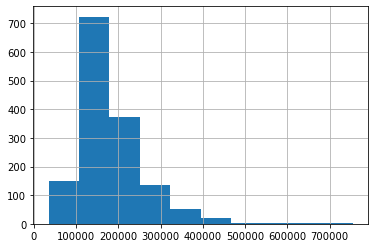

In [42]:
train_df['SalePrice']

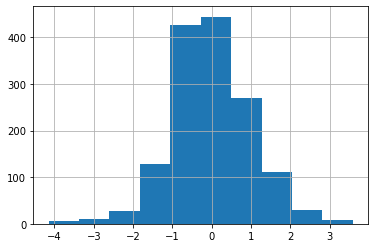

In [44]:
train_df['BoxCoxSalePrice'] = PowerTransformer(method='box-cox').fit_transform(train_df[['SalePrice']])
train_df['BoxCoxSalePrice'].hist()
plt.show()

In [ ]:
train_df['SalePrice'].hist()
plt.show()

In [45]:
skewed_discrete_variables

['BsmtHalfBath', 'KitchenAbvGr']

In [57]:
skew_boxcox_cont_pipeline

Pipeline(steps=[('powertransformer', PowerTransformer(method='box-cox')),
                ('simpleimputer', SimpleImputer())])

In [62]:
preprocessor4 = make_column_transformer((categorical_pipeline2, categorical_variables),
                                       (skew_boxcox_cont_pipeline, skewed_continuous_variables),
                                       (skewed_boxcox_discrete_pipeline, skewed_discrete_variables),
                                       (numerical_imputer, cont_variables),
                                       (categorical_imputer, discrete_variables2),
                                    )

In [72]:
discrete_numerical_variables

['BsmtHalfBath',
 'OverallCond',
 'BedroomAbvGr',
 'MoSold',
 'BsmtFullBath',
 'HalfBath',
 'TotRmsAbvGrd',
 'KitchenAbvGr',
 'OverallQual',
 'YrSold',
 'FullBath',
 'Fireplaces',
 'GarageCars']

In [70]:
skewed_discrete_variables

['BsmtHalfBath', 'KitchenAbvGr']

In [60]:
preprocessor4

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['MSSubClass', 'MSZoning', 'Street',
                                  'LotShape', 'LandContour', 'Utilities',
                                  'LotConfig', 'LandSlope', 'Neighborhood',
                                  'Condition1', 'Condition2', 'BldgType',
                                  'HouseStyle...
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['BsmtHalfBath', 'KitchenAbvGr']),
                                ('simpleimputer-1', SimpleImputer(),
                                 ['GarageYrBlt', 'YearBuilt', 'YearRemodAdd',
                                  'GarageArea', 'PoolArea']),
                                ('simpleimputer-2',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['OverallCond', 'MoSold', 'BedroomAbvGr',
                                  'BsmtFullBath', 'HalfBath', 'TotRmsAbvGrd',
                                  'OverallQual', 'YrSold', 'FullBath',
                                  'Fireplaces', 'GarageCars'])])

### Pipeline with Yeo Johnson Transform

In [65]:
%%time
xgb_final_pipe, xgb_score, xgb_best_params = get_pipeline_cross_val_score(preprocessor4, XGBRegressor, xgb_param_grid, train_low_missing_vals_df, y_train)
lasso_final_pipe, lasso_score, lasso_best_params = get_pipeline_cross_val_score(preprocessor4, Lasso, lasso_param_grid, train_low_missing_vals_df, y_train)
ridge_final_pipe, ridge_score, ridge_best_params = get_pipeline_cross_val_score(preprocessor4, Ridge, ridge_param_grid, train_low_missing_vals_df, y_train)
elastic_net_final_pipe, elastic_net_score, elastic_net_best_params = get_pipeline_cross_val_score(preprocessor4, ElasticNet, elastic_net_param_grid, train_low_missing_vals_df, y_train)
knn_final_pipe, knn_score, knn_best_params = get_pipeline_cross_val_score(preprocessor4, KNeighborsRegressor, knn_param_grid, train_low_missing_vals_df, y_train)

model: <class 'xgboost.sklearn.XGBRegressor'>, class: XGBRegressor
model: <class 'sklearn.linear_model._coordinate_descent.Lasso'>, class: Lasso
scaling


C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 19 is smaller than n_iter=50. Running 19 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Scaling
model: <class 'sklearn.linear_model._ridge.Ridge'>, class: Ridge
scaling


C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 19 is smaller than n_iter=50. Running 19 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Scaling
model: <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>, class: ElasticNet
scaling
Scaling
model: <class 'sklearn.neighbors._regression.KNeighborsRegressor'>, class: KNeighborsRegressor


C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 6 is smaller than n_iter=50. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CPU times: total: 12min 57s
Wall time: 2min 33s


### Stacked Regression with Yeo Johnson Transform

In [66]:
%%time
estimators = [
 ('KNN', knn_final_pipe),
    ('Lasso', lasso_final_pipe),
    ('Ridge', ridge_final_pipe),
    ('Elastic', elastic_net_final_pipe),
    ('XGBRegressor', xgb_final_pipe)
]


final_estimator=RandomForestRegressor()

rf_stacking_regressor = StackingRegressor(
        estimators=estimators,
        final_estimator=final_estimator,
    )

-cross_val_score(rf_stacking_regressor, train_low_missing_vals_df, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

CPU times: total: 1min 26s
Wall time: 26.2 s


0.12351250803795037

In [67]:
rf_stacking_regressor = rf_stacking_regressor.fit(train_low_missing_vals_df, y_train)
test_pred = rf_stacking_regressor.predict(test_low_missing_vals_df)
test_pred = np.expm1(test_pred)
test_df['PredictedSalePrice'] = test_pred
pred = test_df[['Id', 'PredictedSalePrice']]
columns = dict()
columns['PredictedSalePrice'] = 'SalePrice'
pred = pred.rename(columns=columns)
pred.to_csv('rf_stacking_regressor_v3_box_cox_transform.csv', index=False)

In [76]:
cbrt_transformer = FunctionTransformer(np.cbrt)
skew_cbrt_cont_pipeline = make_pipeline(cbrt_transformer, numerical_imputer)

In [77]:
preprocessor5 = make_column_transformer((categorical_pipeline2, categorical_variables),
                                       (skew_cbrt_cont_pipeline, skewed_continuous_variables),
                                       (numerical_imputer, cont_variables),
                                       (categorical_imputer, discrete_variables2 + skewed_discrete_variables),
                                    )

In [216]:
%%time
xgb_final_pipe, xgb_score, xgb_best_params = get_pipeline_cross_val_score(preprocessor5, XGBRegressor, xgb_param_grid, train_low_missing_vals_df, y_train)
lasso_final_pipe, lasso_score, lasso_best_params = get_pipeline_cross_val_score(preprocessor5, Lasso, lasso_param_grid, train_low_missing_vals_df, y_train)
ridge_final_pipe, ridge_score, ridge_best_params = get_pipeline_cross_val_score(preprocessor5, Ridge, ridge_param_grid, train_low_missing_vals_df, y_train)
elastic_net_final_pipe, elastic_net_score, elastic_net_best_params = get_pipeline_cross_val_score(preprocessor5, ElasticNet, elastic_net_param_grid, train_low_missing_vals_df, y_train)
knn_final_pipe, knn_score, knn_best_params = get_pipeline_cross_val_score(preprocessor5, KNeighborsRegressor, knn_param_grid, train_low_missing_vals_df, y_train)

model: <class 'xgboost.sklearn.XGBRegressor'>, class: XGBRegressor
model: <class 'sklearn.linear_model._coordinate_descent.Lasso'>, class: Lasso
scaling


C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 19 is smaller than n_iter=50. Running 19 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Scaling
model: <class 'sklearn.linear_model._ridge.Ridge'>, class: Ridge
scaling


C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 19 is smaller than n_iter=50. Running 19 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Scaling
model: <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>, class: ElasticNet
scaling
Scaling
model: <class 'sklearn.neighbors._regression.KNeighborsRegressor'>, class: KNeighborsRegressor


C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 6 is smaller than n_iter=50. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CPU times: total: 9min 29s
Wall time: 1min 47s


### Cube root transform skew correction with RF Stacked Regressor

In [217]:
%%time

estimators = [
 ('KNN', knn_final_pipe),
    ('Lasso', lasso_final_pipe),
    ('Ridge', ridge_final_pipe),
    ('Elastic', elastic_net_final_pipe),
    ('XGBRegressor', xgb_final_pipe)
]


final_estimator=RandomForestRegressor()

rf_stacking_regressor = StackingRegressor(
        estimators=estimators,
        final_estimator=final_estimator,
    )

-cross_val_score(rf_stacking_regressor, train_low_missing_vals_df, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

CPU times: total: 1min 16s
Wall time: 19.1 s


0.1251497865699299

In [218]:
%%time
rf_stacking_regressor = rf_stacking_regressor.fit(train_low_missing_vals_df, y_train)
test_pred = rf_stacking_regressor.predict(test_low_missing_vals_df)
test_pred = np.expm1(test_pred)
test_df['PredictedSalePrice'] = test_pred
pred = test_df[['Id', 'PredictedSalePrice']]
columns = dict()
columns['PredictedSalePrice'] = 'SalePrice'
pred = pred.rename(columns=columns)
pred.to_csv('rf_stacking_regressor_v4_cbrt_transform.csv', index=False)

CPU times: total: 18.2 s
Wall time: 4.74 s


Removing low variance variables, kind of iffy on some of them for categorical variables

## Retraining models on new dataset

### Evaluating which variables to remove starting from the source training dataset

In [127]:
numerical_columns_selector = selector(dtype_exclude=object)
numerical_columns = numerical_columns_selector(train_df)

categorical_columns_selector = selector(dtype_exclude='number')
categorical_columns = categorical_columns_selector(train_df)

In [138]:
categorical_variables, discrete_numerical_variables,\
continuous_numerical_variables = data_manipulation.get_variables(train_df, [], 'Id')
continuous_numerical_variables = continuous_numerical_variables + ['PoolArea']
discrete_numerical_variables = list(set(discrete_numerical_variables) - set(['PoolArea']))
ind_continuous_variables = list(set(continuous_numerical_variables) - set(['SalePrice', 'LogSalePrice']))
numerical_variables = continuous_numerical_variables + discrete_numerical_variables

### Determining low variance numerical and categorical features from source training dataset

Variable: WoodDeckSF


count    1460.000000
mean       94.244521
std       125.338794
min         0.000000
25%         0.000000
50%         0.000000
75%       168.000000
max       857.000000
Name: WoodDeckSF, dtype: float64

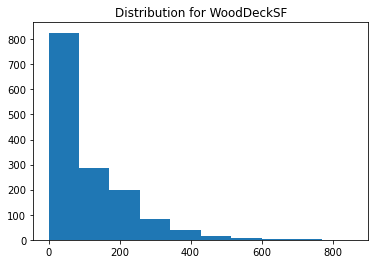

Variable: BsmtFinSF1


count    1460.000000
mean      443.639726
std       456.098091
min         0.000000
25%         0.000000
50%       383.500000
75%       712.250000
max      5644.000000
Name: BsmtFinSF1, dtype: float64

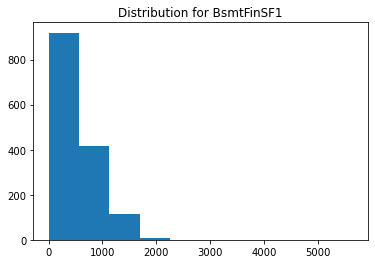

Variable: 2ndFlrSF


count    1460.000000
mean      346.992466
std       436.528436
min         0.000000
25%         0.000000
50%         0.000000
75%       728.000000
max      2065.000000
Name: 2ndFlrSF, dtype: float64

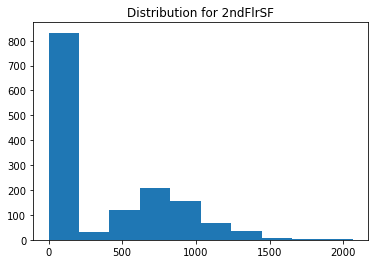

Variable: OpenPorchSF


count    1460.000000
mean       46.660274
std        66.256028
min         0.000000
25%         0.000000
50%        25.000000
75%        68.000000
max       547.000000
Name: OpenPorchSF, dtype: float64

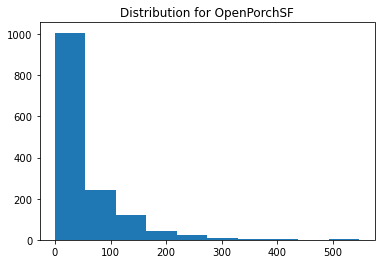

Variable: ScreenPorch


count    1460.000000
mean       15.060959
std        55.757415
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       480.000000
Name: ScreenPorch, dtype: float64

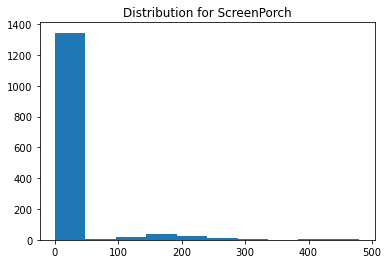

Variable: BsmtUnfSF


count    1460.000000
mean      567.240411
std       441.866955
min         0.000000
25%       223.000000
50%       477.500000
75%       808.000000
max      2336.000000
Name: BsmtUnfSF, dtype: float64

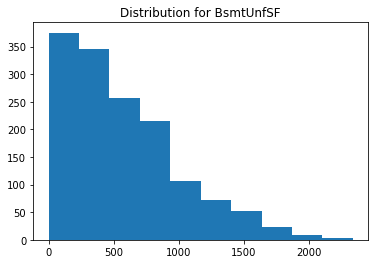

Variable: YearRemodAdd


count    1460.000000
mean     1984.865753
std        20.645407
min      1950.000000
25%      1967.000000
50%      1994.000000
75%      2004.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64

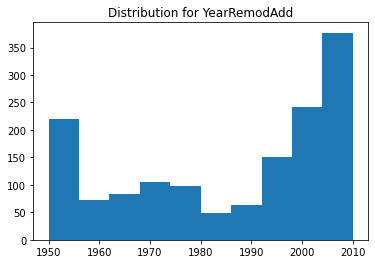

Variable: GrLivArea


count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: GrLivArea, dtype: float64

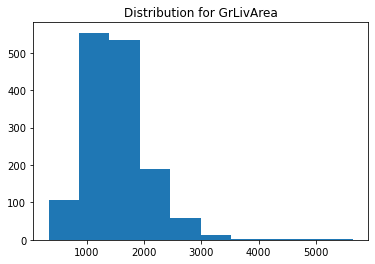

Variable: 1stFlrSF


count    1460.000000
mean     1162.626712
std       386.587738
min       334.000000
25%       882.000000
50%      1087.000000
75%      1391.250000
max      4692.000000
Name: 1stFlrSF, dtype: float64

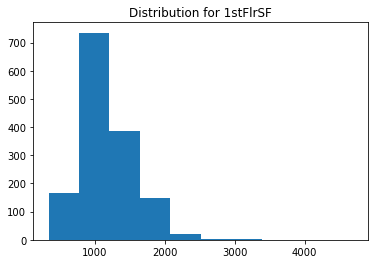

Variable: EnclosedPorch


count    1460.000000
mean       21.954110
std        61.119149
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       552.000000
Name: EnclosedPorch, dtype: float64

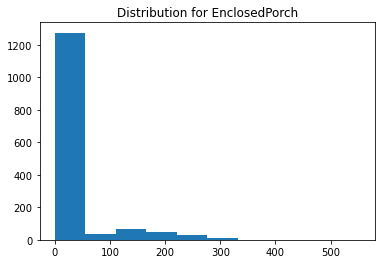

Variable: LotFrontage


count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

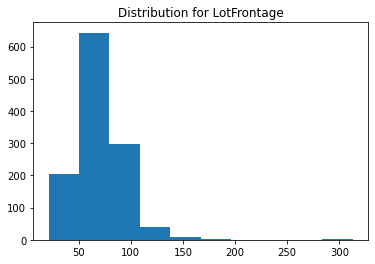

Variable: BsmtFinSF2


count    1460.000000
mean       46.549315
std       161.319273
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1474.000000
Name: BsmtFinSF2, dtype: float64

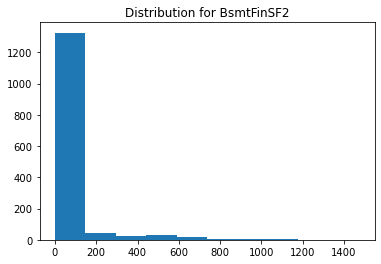

Variable: GarageYrBlt


count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

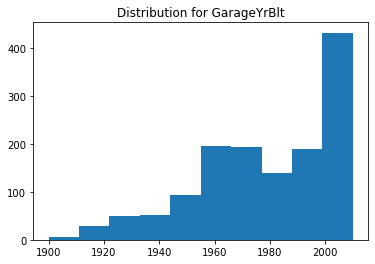

Variable: YearBuilt


count    1460.000000
mean     1971.267808
std        30.202904
min      1872.000000
25%      1954.000000
50%      1973.000000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64

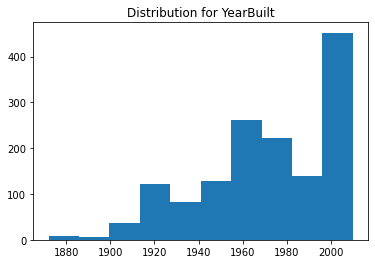

Variable: LowQualFinSF


count    1460.000000
mean        5.844521
std        48.623081
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       572.000000
Name: LowQualFinSF, dtype: float64

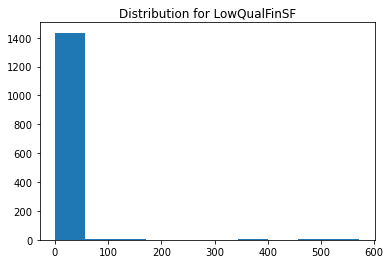

Variable: 3SsnPorch


count    1460.000000
mean        3.409589
std        29.317331
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       508.000000
Name: 3SsnPorch, dtype: float64

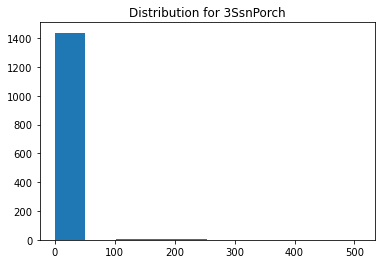

Variable: TotalBsmtSF


count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       795.750000
50%       991.500000
75%      1298.250000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

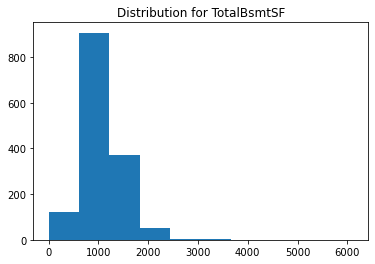

Variable: MasVnrArea


count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

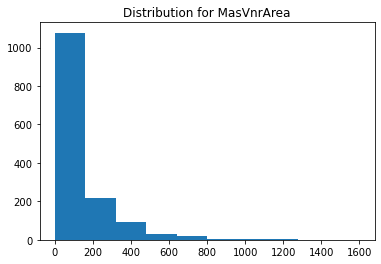

Variable: MiscVal


count     1460.000000
mean        43.489041
std        496.123024
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      15500.000000
Name: MiscVal, dtype: float64

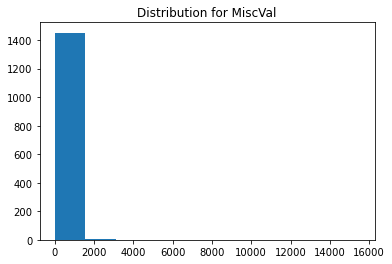

Variable: PoolArea


count    1460.000000
mean        2.758904
std        40.177307
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       738.000000
Name: PoolArea, dtype: float64

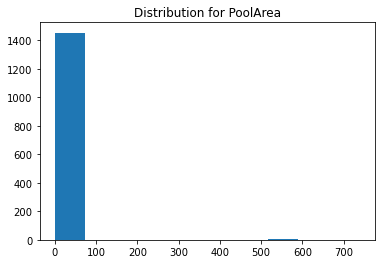

Variable: LotArea


count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
25%        7553.500000
50%        9478.500000
75%       11601.500000
max      215245.000000
Name: LotArea, dtype: float64

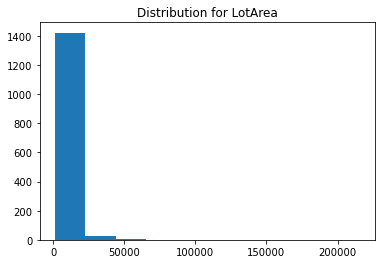

Variable: GarageArea


count    1460.000000
mean      472.980137
std       213.804841
min         0.000000
25%       334.500000
50%       480.000000
75%       576.000000
max      1418.000000
Name: GarageArea, dtype: float64

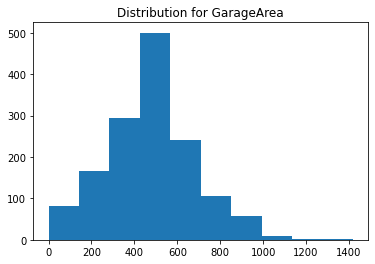

In [150]:
plot_variable_dist(train_df, ind_continuous_variables)

removed BsmtFinSF2, EnclosedPorch from this list

In [158]:
low_variance_num_vars = ["ScreenPorch", "BsmtFinSF2", "LowQualFinSF", "3SsnPorch", "MiscVal", "PoolArea", "EnclosedPorch"]

In [159]:
for v in low_variance_num_vars:
    num_obs_gt_0 = train_df[train_df[v] > 0].shape[0]
    pct = round(num_obs_gt_0*100/train_df.shape[0], 2)
    print(f'Variable: {v}, num obs > 0: {num_obs_gt_0}, {pct}%')

Variable: ScreenPorch, num obs > 0: 116, 7.95%
Variable: BsmtFinSF2, num obs > 0: 167, 11.44%
Variable: LowQualFinSF, num obs > 0: 26, 1.78%
Variable: 3SsnPorch, num obs > 0: 24, 1.64%
Variable: MiscVal, num obs > 0: 52, 3.56%
Variable: PoolArea, num obs > 0: 7, 0.48%
Variable: EnclosedPorch, num obs > 0: 208, 14.25%


Variable: BsmtHalfBath


0    0.943836
1    0.054795
2    0.001370
Name: BsmtHalfBath, dtype: float64

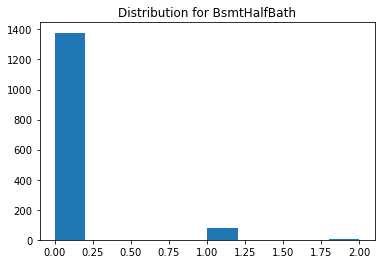

Variable: OverallCond


5    0.562329
6    0.172603
7    0.140411
8    0.049315
4    0.039041
3    0.017123
9    0.015068
2    0.003425
1    0.000685
Name: OverallCond, dtype: float64

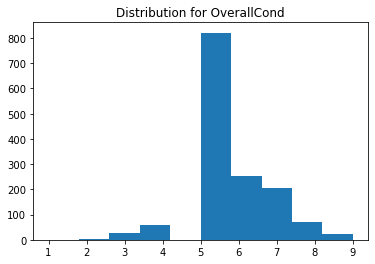

Variable: BedroomAbvGr


3    0.550685
2    0.245205
4    0.145890
1    0.034247
5    0.014384
6    0.004795
0    0.004110
8    0.000685
Name: BedroomAbvGr, dtype: float64

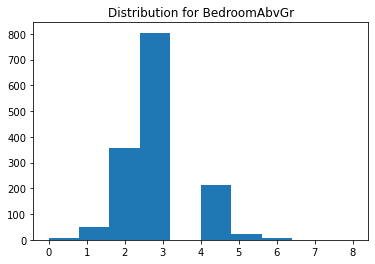

Variable: MoSold


6     0.173288
7     0.160274
5     0.139726
4     0.096575
8     0.083562
3     0.072603
10    0.060959
11    0.054110
9     0.043151
12    0.040411
1     0.039726
2     0.035616
Name: MoSold, dtype: float64

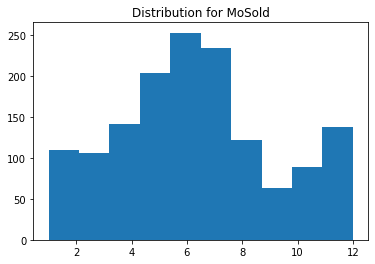

Variable: BsmtFullBath


0    0.586301
1    0.402740
2    0.010274
3    0.000685
Name: BsmtFullBath, dtype: float64

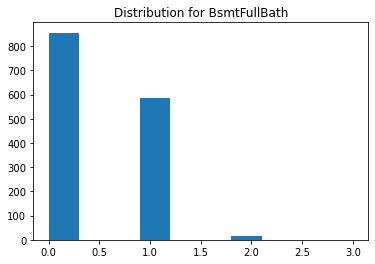

Variable: HalfBath


0    0.625342
1    0.366438
2    0.008219
Name: HalfBath, dtype: float64

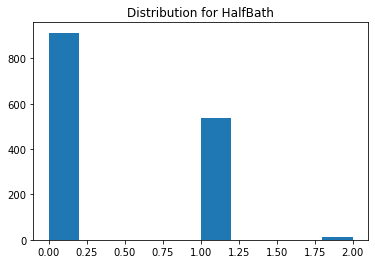

Variable: TotRmsAbvGrd


6     0.275342
7     0.225342
5     0.188356
8     0.128082
4     0.066438
9     0.051370
10    0.032192
11    0.012329
3     0.011644
12    0.007534
2     0.000685
14    0.000685
Name: TotRmsAbvGrd, dtype: float64

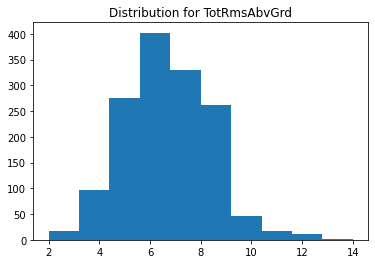

Variable: KitchenAbvGr


1    0.953425
2    0.044521
3    0.001370
0    0.000685
Name: KitchenAbvGr, dtype: float64

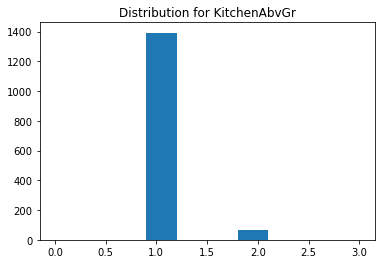

Variable: OverallQual


5     0.271918
6     0.256164
7     0.218493
8     0.115068
4     0.079452
9     0.029452
3     0.013699
10    0.012329
2     0.002055
1     0.001370
Name: OverallQual, dtype: float64

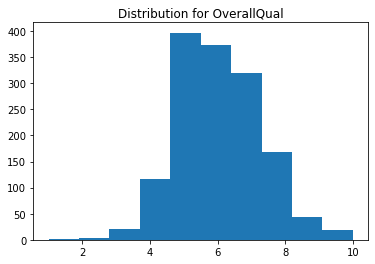

Variable: YrSold


2009    0.231507
2007    0.225342
2006    0.215068
2008    0.208219
2010    0.119863
Name: YrSold, dtype: float64

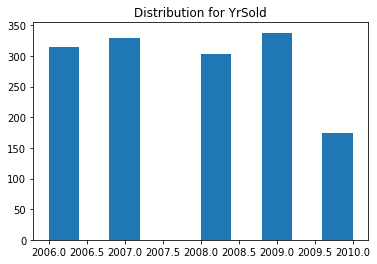

Variable: FullBath


2    0.526027
1    0.445205
3    0.022603
0    0.006164
Name: FullBath, dtype: float64

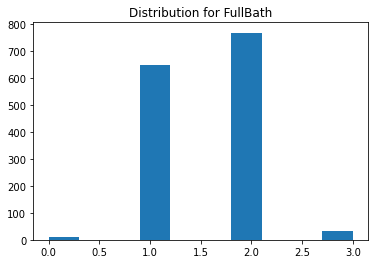

Variable: Fireplaces


0    0.472603
1    0.445205
2    0.078767
3    0.003425
Name: Fireplaces, dtype: float64

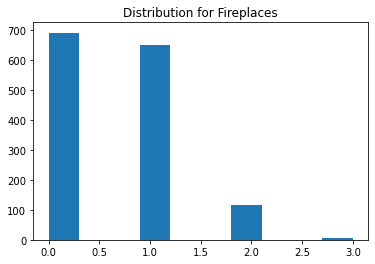

Variable: GarageCars


2    0.564384
1    0.252740
3    0.123973
0    0.055479
4    0.003425
Name: GarageCars, dtype: float64

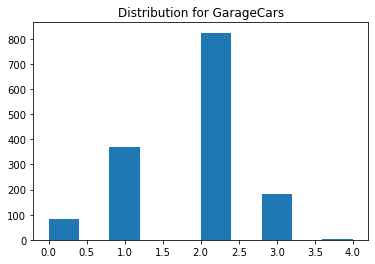

In [163]:
plot_discrete_variable_dist(train_df, discrete_numerical_variables)

Variable: MSSubClass


20     0.367123
60     0.204795
50     0.098630
120    0.059589
30     0.047260
160    0.043151
70     0.041096
80     0.039726
90     0.035616
190    0.020548
85     0.013699
75     0.010959
45     0.008219
180    0.006849
40     0.002740
Name: MSSubClass, dtype: float64

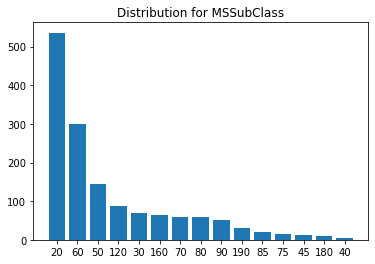

Variable: MSZoning


RL    0.788356
RM    0.149315
FV    0.044521
RH    0.010959
C     0.006849
Name: MSZoning, dtype: float64

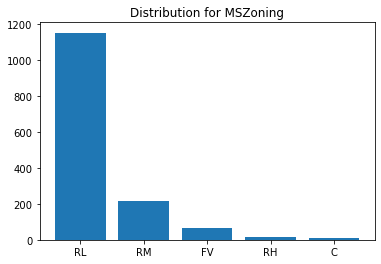

Variable: Street


Pave    0.99589
Grvl    0.00411
Name: Street, dtype: float64

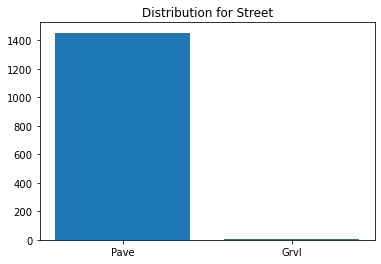

Variable: Alley


Grvl    0.549451
Pave    0.450549
Name: Alley, dtype: float64

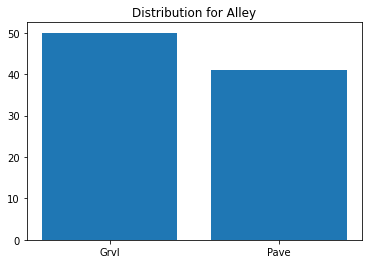

Variable: LotShape


Reg    0.633562
IR1    0.331507
IR2    0.028082
IR3    0.006849
Name: LotShape, dtype: float64

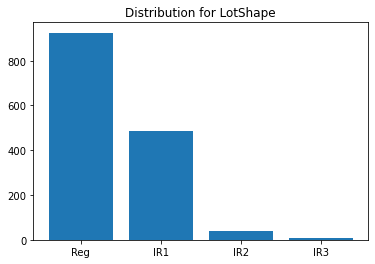

Variable: LandContour


Lvl    0.897945
Bnk    0.043151
HLS    0.034247
Low    0.024658
Name: LandContour, dtype: float64

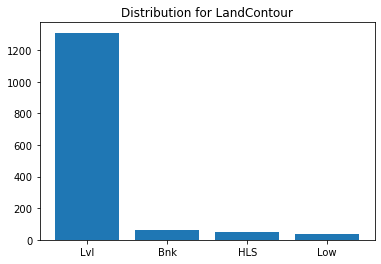

Variable: Utilities


AllPub    0.999315
NoSeWa    0.000685
Name: Utilities, dtype: float64

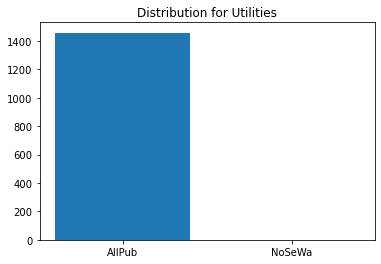

Variable: LotConfig


Inside     0.720548
Corner     0.180137
CulDSac    0.064384
FR2        0.032192
FR3        0.002740
Name: LotConfig, dtype: float64

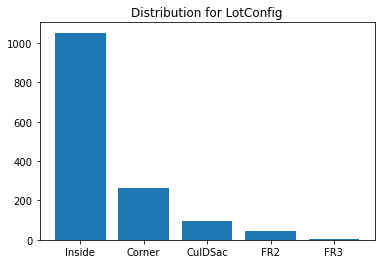

Variable: LandSlope


Gtl    0.946575
Mod    0.044521
Sev    0.008904
Name: LandSlope, dtype: float64

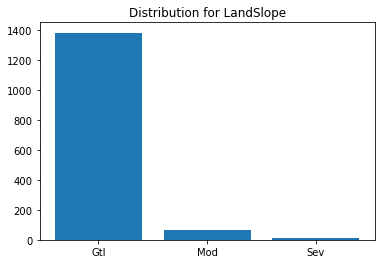

Variable: Neighborhood


NAmes      0.154110
CollgCr    0.102740
OldTown    0.077397
Edwards    0.068493
Somerst    0.058904
Gilbert    0.054110
NridgHt    0.052740
Sawyer     0.050685
NWAmes     0.050000
SawyerW    0.040411
BrkSide    0.039726
Crawfor    0.034932
Mitchel    0.033562
NoRidge    0.028082
Timber     0.026027
IDOTRR     0.025342
ClearCr    0.019178
StoneBr    0.017123
SWISU      0.017123
MeadowV    0.011644
Blmngtn    0.011644
BrDale     0.010959
Veenker    0.007534
NPkVill    0.006164
Blueste    0.001370
Name: Neighborhood, dtype: float64

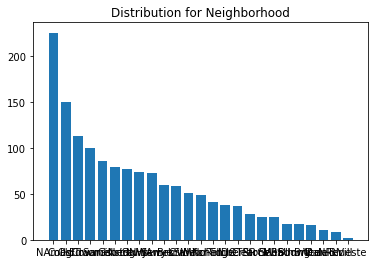

Variable: Condition1


Norm      0.863014
Feedr     0.055479
Artery    0.032877
RRAn      0.017808
PosN      0.013014
RRAe      0.007534
PosA      0.005479
RRNn      0.003425
RRNe      0.001370
Name: Condition1, dtype: float64

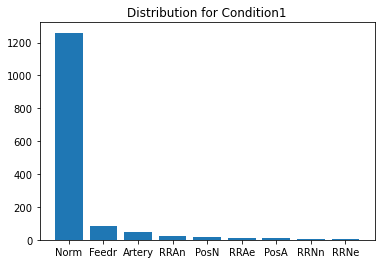

Variable: Condition2


Norm      0.989726
Feedr     0.004110
Artery    0.001370
RRNn      0.001370
PosN      0.001370
PosA      0.000685
RRAn      0.000685
RRAe      0.000685
Name: Condition2, dtype: float64

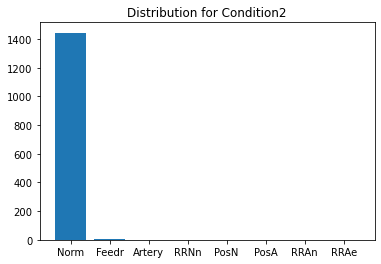

Variable: BldgType


1Fam      0.835616
TwnhsE    0.078082
Duplex    0.035616
Twnhs     0.029452
2fmCon    0.021233
Name: BldgType, dtype: float64

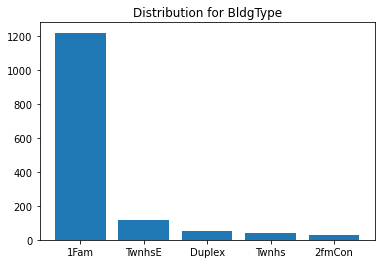

Variable: HouseStyle


1Story    0.497260
2Story    0.304795
1.5Fin    0.105479
SLvl      0.044521
SFoyer    0.025342
1.5Unf    0.009589
2.5Unf    0.007534
2.5Fin    0.005479
Name: HouseStyle, dtype: float64

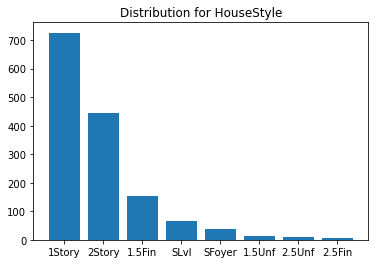

Variable: RoofStyle


Gable      0.781507
Hip        0.195890
Flat       0.008904
Gambrel    0.007534
Mansard    0.004795
Shed       0.001370
Name: RoofStyle, dtype: float64

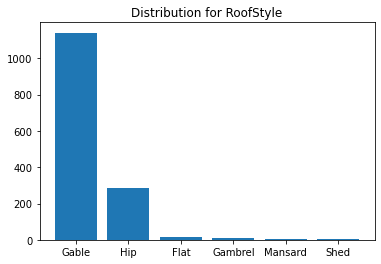

Variable: RoofMatl


CompShg    0.982192
Tar&Grv    0.007534
WdShngl    0.004110
WdShake    0.003425
Metal      0.000685
Membran    0.000685
Roll       0.000685
ClyTile    0.000685
Name: RoofMatl, dtype: float64

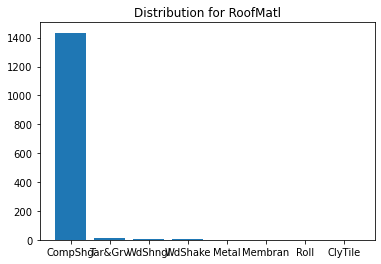

Variable: Exterior1st


VinylSd    0.352740
HdBoard    0.152055
MetalSd    0.150685
Wd Sdng    0.141096
Plywood    0.073973
CemntBd    0.041781
BrkFace    0.034247
WdShing    0.017808
Stucco     0.017123
AsbShng    0.013699
BrkComm    0.001370
Stone      0.001370
AsphShn    0.000685
ImStucc    0.000685
CBlock     0.000685
Name: Exterior1st, dtype: float64

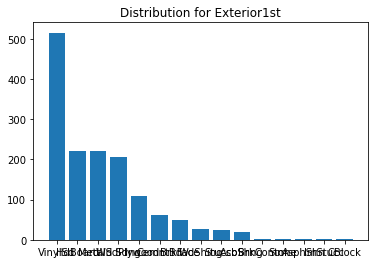

Variable: Exterior2nd


VinylSd    0.345205
MetalSd    0.146575
HdBoard    0.141781
Wd Sdng    0.134932
Plywood    0.097260
CmentBd    0.041096
Wd Shng    0.026027
Stucco     0.017808
BrkFace    0.017123
AsbShng    0.013699
ImStucc    0.006849
Brk Cmn    0.004795
Stone      0.003425
AsphShn    0.002055
Other      0.000685
CBlock     0.000685
Name: Exterior2nd, dtype: float64

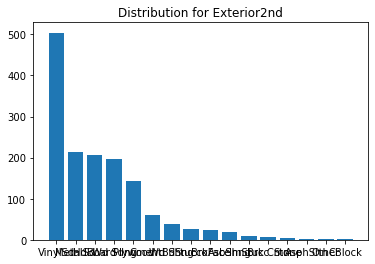

Variable: MasVnrType


None       0.595041
BrkFace    0.306474
Stone      0.088154
BrkCmn     0.010331
Name: MasVnrType, dtype: float64

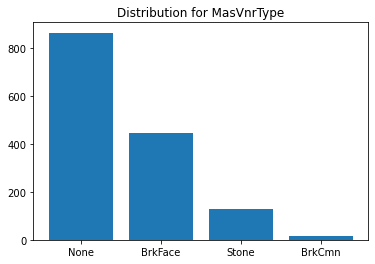

Variable: ExterQual


TA    0.620548
Gd    0.334247
Ex    0.035616
Fa    0.009589
Name: ExterQual, dtype: float64

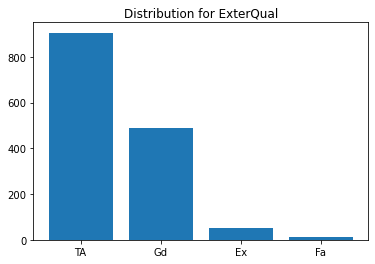

Variable: ExterCond


TA    0.878082
Gd    0.100000
Fa    0.019178
Ex    0.002055
Po    0.000685
Name: ExterCond, dtype: float64

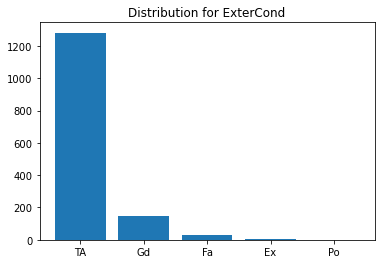

Variable: Foundation


PConc     0.443151
CBlock    0.434247
BrkTil    0.100000
Slab      0.016438
Stone     0.004110
Wood      0.002055
Name: Foundation, dtype: float64

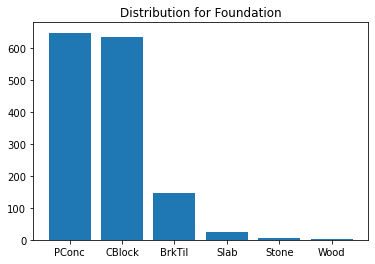

Variable: BsmtQual


TA    0.456079
Gd    0.434294
Ex    0.085032
Fa    0.024596
Name: BsmtQual, dtype: float64

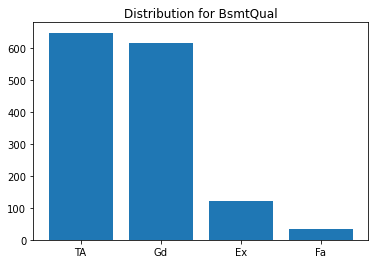

Variable: BsmtCond


TA    0.921293
Gd    0.045678
Fa    0.031623
Po    0.001405
Name: BsmtCond, dtype: float64

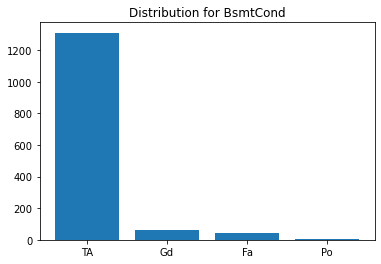

Variable: BsmtExposure


No    0.670183
Av    0.155415
Gd    0.094233
Mn    0.080169
Name: BsmtExposure, dtype: float64

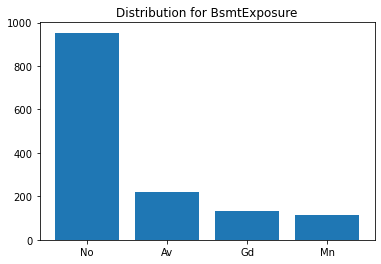

Variable: BsmtFinType1


Unf    0.302178
GLQ    0.293746
ALQ    0.154603
BLQ    0.104006
Rec    0.093465
LwQ    0.052003
Name: BsmtFinType1, dtype: float64

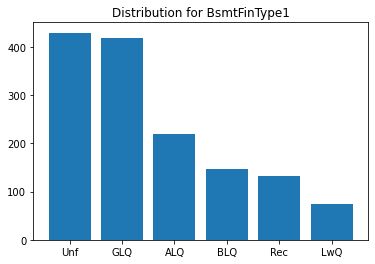

Variable: BsmtFinType2


Unf    0.883263
Rec    0.037975
LwQ    0.032349
BLQ    0.023207
ALQ    0.013361
GLQ    0.009845
Name: BsmtFinType2, dtype: float64

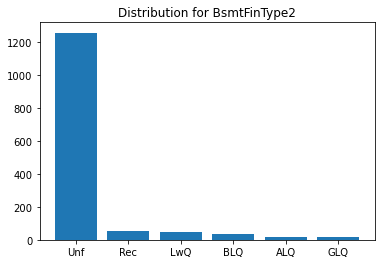

Variable: Heating


GasA     0.978082
GasW     0.012329
Grav     0.004795
Wall     0.002740
OthW     0.001370
Floor    0.000685
Name: Heating, dtype: float64

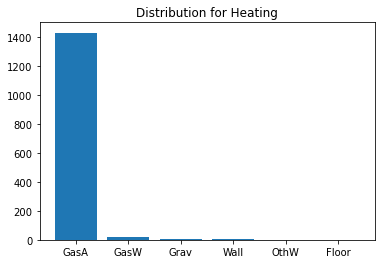

Variable: HeatingQC


Ex    0.507534
TA    0.293151
Gd    0.165068
Fa    0.033562
Po    0.000685
Name: HeatingQC, dtype: float64

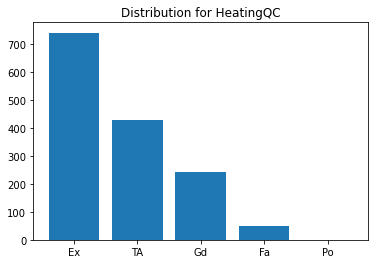

Variable: CentralAir


Y    0.934932
N    0.065068
Name: CentralAir, dtype: float64

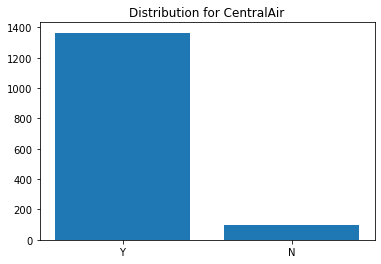

Variable: Electrical


SBrkr    0.914325
FuseA    0.064428
FuseF    0.018506
FuseP    0.002056
Mix      0.000685
Name: Electrical, dtype: float64

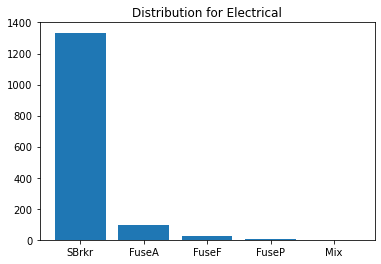

Variable: KitchenQual


TA    0.503425
Gd    0.401370
Ex    0.068493
Fa    0.026712
Name: KitchenQual, dtype: float64

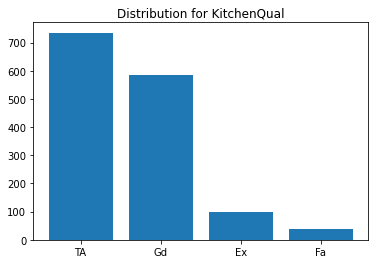

Variable: Functional


Typ     0.931507
Min2    0.023288
Min1    0.021233
Mod     0.010274
Maj1    0.009589
Maj2    0.003425
Sev     0.000685
Name: Functional, dtype: float64

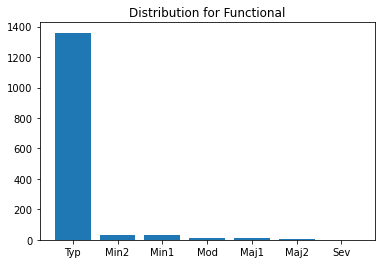

Variable: FireplaceQu


Gd    0.493506
TA    0.406494
Fa    0.042857
Ex    0.031169
Po    0.025974
Name: FireplaceQu, dtype: float64

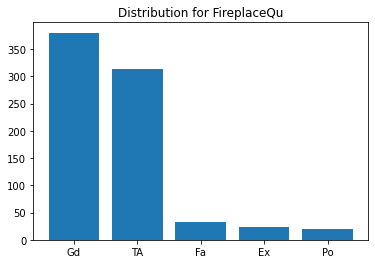

Variable: GarageType


Attchd     0.630892
Detchd     0.280638
BuiltIn    0.063814
Basment    0.013778
CarPort    0.006526
2Types     0.004351
Name: GarageType, dtype: float64

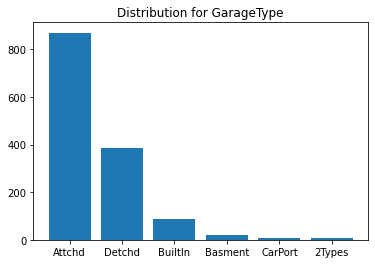

Variable: GarageFinish


Unf    0.438724
RFn    0.306019
Fin    0.255257
Name: GarageFinish, dtype: float64

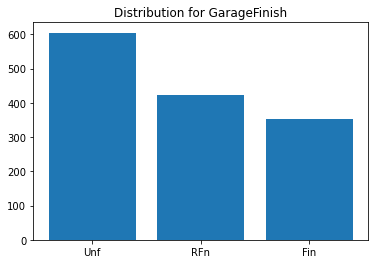

Variable: GarageQual


TA    0.950689
Fa    0.034808
Gd    0.010152
Ex    0.002175
Po    0.002175
Name: GarageQual, dtype: float64

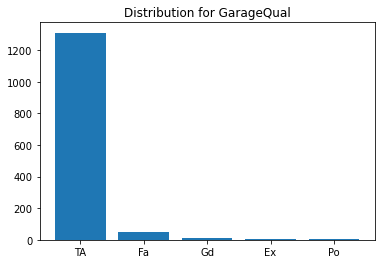

Variable: GarageCond


TA    0.961566
Fa    0.025381
Gd    0.006526
Po    0.005076
Ex    0.001450
Name: GarageCond, dtype: float64

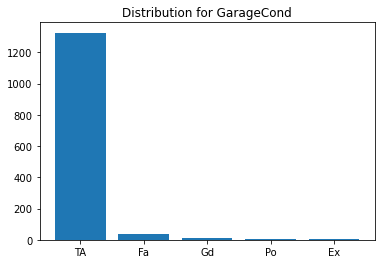

Variable: PavedDrive


Y    0.917808
N    0.061644
P    0.020548
Name: PavedDrive, dtype: float64

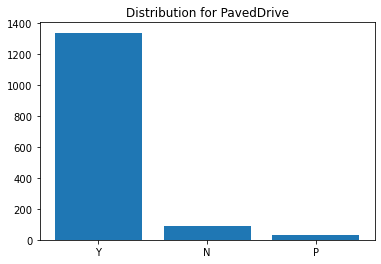

Variable: PoolQC


Gd    0.428571
Ex    0.285714
Fa    0.285714
Name: PoolQC, dtype: float64

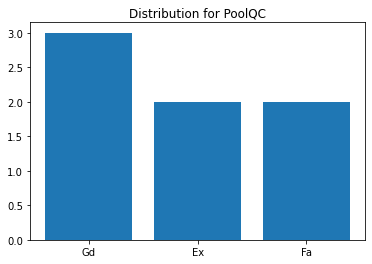

Variable: Fence


MnPrv    0.558719
GdPrv    0.209964
GdWo     0.192171
MnWw     0.039146
Name: Fence, dtype: float64

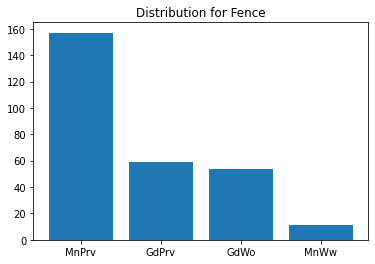

Variable: MiscFeature


Shed    0.907407
Gar2    0.037037
Othr    0.037037
TenC    0.018519
Name: MiscFeature, dtype: float64

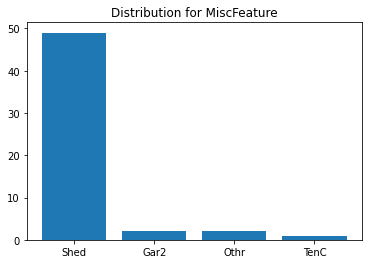

Variable: SaleType


WD       0.867808
New      0.083562
COD      0.029452
ConLD    0.006164
ConLI    0.003425
ConLw    0.003425
CWD      0.002740
Oth      0.002055
Con      0.001370
Name: SaleType, dtype: float64

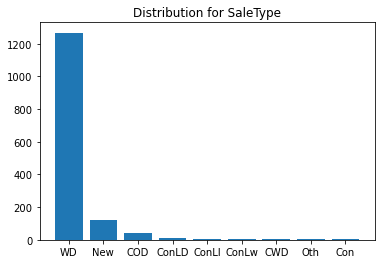

Variable: SaleCondition


Normal     0.820548
Partial    0.085616
Abnorml    0.069178
Family     0.013699
Alloca     0.008219
AdjLand    0.002740
Name: SaleCondition, dtype: float64

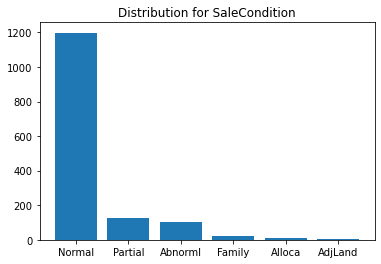

In [174]:
plot_cat_variable_dist(train_df, categorical_columns)

In [175]:
low_variance_cont_num_vars = ["ScreenPorch", "BsmtFinSF2", "LowQualFinSF", "3SsnPorch", "MiscVal", "PoolArea"]

low_variance_discrete_num_vars = ["BsmtHalfBath", "KitchenAbvGr"]

low_variance_cat_vars = ["Street", "Utilities", "LandSlope", "Condition2", "RoofMatl", "BsmtCond", "Heating", "CentralAir",\
                         "Electrical", "Functional", "GarageQual", "GarageCond", "PavedDrive", "MiscFeature"]

low_variance_num_vars = low_variance_cont_num_vars + low_variance_discrete_num_vars

low_variance_vars = low_variance_num_vars + low_variance_cat_vars
len(low_variance_vars) # MiscFeature has a lot of missing values I guess, so it will be ignored

22

In [177]:
train_no_low_var = train_low_missing_vals_df.drop(low_variance_vars, axis='columns', errors='ignore')
test_no_low_var = test_low_missing_vals_df.drop(low_variance_vars, axis='columns', errors='ignore')

In [181]:
train_no_low_var.shape

(1460, 56)

## Method 2: Removing Low variance features from training data

#### Getting the cat, disc, and continuous variables for high variance features

In [219]:
numerical_columns_selector = selector(dtype_exclude=object)

numerical_columns = numerical_columns_selector(train_no_low_var)
numerical_columns = list(set(numerical_columns) - set(['SalePrice', 'LogSalePrice', 'Id']))


In [220]:
categorical_variables, discrete_numerical_variables,\
continuous_numerical_variables = data_manipulation.get_variables(train_no_low_var, [], 'Id')
continuous_numerical_variables = continuous_numerical_variables
discrete_numerical_variables = list(set(discrete_numerical_variables) - set(['PoolArea']))
ind_continuous_variables = list(set(continuous_numerical_variables) - set(['SalePrice', 'LogSalePrice']))
numerical_variables = continuous_numerical_variables + discrete_numerical_variables

In [221]:
categorical_columns_selector = selector(dtype_exclude='number')
categorical_columns = categorical_columns_selector(train_no_low_var)

In [222]:
skewed_feats = train_no_low_var[numerical_columns].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75].index

In [223]:
skewed_continuous_variables = list(set(skewed_feats).intersection(set(ind_continuous_variables)))
cont_variables = list(set(ind_continuous_variables) - set(skewed_continuous_variables))

In [226]:
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')
ordinal_imputer = SimpleImputer(strategy='most_frequent')

In [227]:
ohe2 = OneHotEncoder(handle_unknown='ignore', sparse=False)
categorical_pipeline2 = make_pipeline(categorical_imputer, ohe2)
skewed_numerical_pipeline = make_pipeline(log_transformer, numerical_imputer)


In [228]:
preprocessor3 = make_column_transformer((categorical_pipeline2, categorical_columns),
                                       (skewed_numerical_pipeline, skewed_continuous_variables),
                                       (numerical_imputer, cont_variables),
                                       (categorical_imputer, discrete_numerical_variables),
                                    )

In [230]:
%%time
xgb_final_pipe, xgb_score, xgb_best_params = get_pipeline_cross_val_score(preprocessor3, XGBRegressor, xgb_param_grid, train_no_low_var, y_train)
lasso_final_pipe, lasso_score, lasso_best_params = get_pipeline_cross_val_score(preprocessor3, Lasso, lasso_param_grid, train_no_low_var, y_train)
ridge_final_pipe, ridge_score, ridge_best_params = get_pipeline_cross_val_score(preprocessor3, Ridge, ridge_param_grid, train_no_low_var, y_train)
elastic_net_final_pipe, elastic_net_score, elastic_net_best_params = get_pipeline_cross_val_score(preprocessor3, ElasticNet, elastic_net_param_grid, train_no_low_var, y_train)
knn_final_pipe, knn_score, knn_best_params = get_pipeline_cross_val_score(preprocessor3, KNeighborsRegressor, knn_param_grid, train_no_low_var, y_train)

model: <class 'xgboost.sklearn.XGBRegressor'>, class: XGBRegressor
model: <class 'sklearn.linear_model._coordinate_descent.Lasso'>, class: Lasso
scaling


C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 19 is smaller than n_iter=50. Running 19 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Scaling
model: <class 'sklearn.linear_model._ridge.Ridge'>, class: Ridge
scaling


C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 19 is smaller than n_iter=50. Running 19 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Scaling
model: <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>, class: ElasticNet
scaling
Scaling
model: <class 'sklearn.neighbors._regression.KNeighborsRegressor'>, class: KNeighborsRegressor


C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 6 is smaller than n_iter=50. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CPU times: total: 8min 29s
Wall time: 1min 51s


### Version 5: OG Stacking Regressor without low variance features

In [231]:
%%time

estimators = [
 ('KNN', knn_final_pipe),
    ('Lasso', lasso_final_pipe),
    ('Ridge', ridge_final_pipe),
    ('Elastic', elastic_net_final_pipe),
    ('XGBRegressor', xgb_final_pipe)
]


final_estimator=RandomForestRegressor()

rf_stacking_regressor = StackingRegressor(
        estimators=estimators,
        final_estimator=final_estimator,
    )

-cross_val_score(rf_stacking_regressor, train_no_low_var, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()

CPU times: total: 1min 13s
Wall time: 21.8 s


0.12766740241047062

In [232]:
%%time
rf_stacking_regressor = rf_stacking_regressor.fit(train_no_low_var, y_train)
test_pred = rf_stacking_regressor.predict(test_no_low_var)
test_pred = np.expm1(test_pred)
test_df['PredictedSalePrice'] = test_pred
pred = test_df[['Id', 'PredictedSalePrice']]
columns = dict()
columns['PredictedSalePrice'] = 'SalePrice'
pred = pred.rename(columns=columns)
pred.to_csv('stacking_regressor_no_low_var.csv', index=False)

CPU times: total: 14.5 s
Wall time: 4.21 s
